In [1]:
from BhuDM import *
from utils import *
import warnings
import yaml
try:
    from yaml import Cloader as Loader
except ImportError:

    from yaml import Loader

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from tensorflow.keras import layers
from tensorflow.keras import models, callbacks, optimizers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
import matplotlib.pyplot as plt
import os
import pickle

In [51]:
config_file="phase2_paleotopography.yaml"
with open(config_file) as f:
    PARAMS = yaml.load(f, Loader=Loader)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(" Parameters set from %s" % config_file)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
 Parameters set from phase2_paleotopography.yaml
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Generate random data
def generate_data(num_samples, input_shape):
    X = np.random.randn(num_samples, input_shape).astype(np.float32)
    y = np.random.randint(0, 2, num_samples).astype(np.float32)
    return torch.tensor(X), torch.tensor(y).view(-1, 1)

# Training function
def train_model(model, criterion, optimizer, X_train, y_train, epochs=10, batch_size=32):
    model.train()
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

# Example usage
input_shape = 10  # Example input shape
num_samples = 1000  # Number of samples

# Generate data
X_train, y_train = generate_data(num_samples, input_shape)

# Create the model
model = SimpleNN(input_shape)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, criterion, optimizer, X_train, y_train, epochs=10, batch_size=32)

# Print the model summary
print(model)


Epoch 1, Loss: 0.7681521372869611
Epoch 2, Loss: 0.7462946884334087
Epoch 3, Loss: 0.728566249832511
Epoch 4, Loss: 0.7018874231725931
Epoch 5, Loss: 0.7169258445501328
Epoch 6, Loss: 0.6998047363013029
Epoch 7, Loss: 0.6967066116631031
Epoch 8, Loss: 0.7059231586754322
Epoch 9, Loss: 0.6860669925808907
Epoch 10, Loss: 0.6866286471486092
SimpleNN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [53]:
def plotgdf(gdf,model,column=None,mollweide=False,time=0,cbar=False,quick=True,**kwargs):
    
    cmap = kwargs.get('cmap', None)
    vmin = kwargs.get('vmin', None)
    vmax = kwargs.get('vmax', None)
    label = kwargs.get('label', None)
    title=kwargs.get('title', None)
    features=kwargs.get('features',True)
    color=kwargs.get('color',None)
    markersize=kwargs.get('markersize',10)
    orientation=kwargs.get('orientation','vertical')
    shrink=kwargs.get('shrink',0.5)
    extend=kwargs.get('extend',None)
    
    central_longitude=kwargs.get('central_longitude',0)
    figsize=kwargs.get('figsize',(12,8))
    
    
    
    
    
    
    fig = plt.figure(figsize=figsize, dpi=300)
    gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents, time=time)

    if mollweide:
        ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = central_longitude))
        ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))
    
        mollweide_proj = f"+proj=moll +lon_0={central_longitude} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
        # gdf=gdf.to_crs(mollweide_proj)
    else:
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude = central_longitude))
        ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    
        
        
    if features:
    
        # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
        gplot.time = time # Ma
        # gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
        # gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
        # gplot.plot_continents(ax, facecolor='grey', alpha=0.2)
        gplot.plot_coastlines(ax, color='skyblue',alpha=0.3)
        # gplot.plot_ridges_and_transforms(ax, color='red')
        gplot.plot_trenches(ax, color='k')
        gplot.plot_subduction_teeth(ax, color='k')
    
    
        # Plot the GeoDataFrame
    
    if quick:
        da=df_to_NetCDF(x=gdf["Longitude"],y=gdf["Latitude"],z=gdf[column])
        plot=gplot.plot_grid(ax=ax, grid=da,**{'cmap':cmap,'vmax':vmax,'vmin': vmin})
    else:
        plot = gdf.plot(ax=ax, cmap=cmap, column=column,vmax=vmax,vmin=vmin,color=color,markersize=markersize)
    

    # ds[column].plot(ax=ax,vmin=vmin,vmax=vmax, cbar_kwargs={'orientation':'horizontal','shrink':0.5,
    #                                           'label':f'{column}'})
    if cbar:
        # Create a ScalarMappable object
        sm = cm.ScalarMappable(cmap=cmap)
        sm.set_array(gdf[column])
        sm.set_clim(vmin, vmax)
        
        # Add colorbar using the same Axes object used for plotting
        colorbar = plt.colorbar(sm, ax=ax, orientation=orientation,shrink=shrink,extend=extend, label=label)
        colorbar.set_label(label)
    
    ax.set_global()
    
    return ax    
    

def plotgdf(gdf,model,column=None,mollweide=False,time=0,cbar=False,quick=True,**kwargs):
    
    cmap = kwargs.get('cmap', None)
    vmin = kwargs.get('vmin', None)
    vmax = kwargs.get('vmax', None)
    label = kwargs.get('label', None)
    title=kwargs.get('title', None)
    features=kwargs.get('features',True)
    color=kwargs.get('color',None)
    markersize=kwargs.get('markersize',10)
    orientation=kwargs.get('orientation','vertical')
    shrink=kwargs.get('shrink',0.5)
    extend=kwargs.get('extend',None)
    
    central_longitude=kwargs.get('central_longitude',0)
    figsize=kwargs.get('figsize',(12,8))
    
    
    
    
    
    
    fig = plt.figure(figsize=figsize, dpi=300)
    gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents, time=time)

    if mollweide:
        ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = central_longitude))
        ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))
    
        mollweide_proj = f"+proj=moll +lon_0={central_longitude} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
        # gdf=gdf.to_crs(mollweide_proj)
    else:
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude = central_longitude))
        ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    
        
        
    if features:
    
        # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
        gplot.time = time # Ma
        # gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
        # gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
        # gplot.plot_continents(ax, facecolor='grey', alpha=0.2)
        gplot.plot_coastlines(ax, color='skyblue',alpha=0.3)
        # gplot.plot_ridges_and_transforms(ax, color='red')
        gplot.plot_trenches(ax, color='k')
        gplot.plot_subduction_teeth(ax, color='k')
    
    
        # Plot the GeoDataFrame
    
    if quick:
        da=df_to_NetCDF(x=gdf["Longitude"],y=gdf["Latitude"],z=gdf[column])
        plot=gplot.plot_grid(ax=ax, grid=da,**{'cmap':cmap,'vmax':vmax,'vmin': vmin})
    else:
        plot = gdf.plot(ax=ax, cmap=cmap, column=column,vmax=vmax,vmin=vmin,color=color,markersize=markersize)
    

    # ds[column].plot(ax=ax,vmin=vmin,vmax=vmax, cbar_kwargs={'orientation':'horizontal','shrink':0.5,
    #                                           'label':f'{column}'})
    if cbar:
        # Create a ScalarMappable object
        sm = cm.ScalarMappable(cmap=cmap)
        sm.set_array(gdf[column])
        sm.set_clim(vmin, vmax)
        
        # Add colorbar using the same Axes object used for plotting
        colorbar = plt.colorbar(sm, ax=ax, orientation=orientation,shrink=shrink,extend=extend, label=label)
        colorbar.set_label(label)
    
    ax.set_global()
    
    return ax    
    


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from tensorflow.keras import layers
from tensorflow.keras import models, callbacks, optimizers

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from tensorflow.keras import layers, models, callbacks, optimizers

class DLModel:
    def __init__(self, training_df, training_variables, target_variable, nodes=8, n_epoch=20, dropout=0.2, bn=True, lr="OnPlateau", scaler="RobustScaler"):
        self.df = training_df.copy()
        self.columns = training_variables
        self.target_variable = target_variable
        self.nodes = max(8, nodes)
        self.n_epoch = n_epoch
        self.dropout = dropout
        self.bn = bn
        self.lr = lr
        self.scaler = scaler
        self.model = None
        self.scaler1 = None
        self.scaler2 = None
        self.history = None
    
    def fit(self):
        features_nan = self.df[self.columns].copy()
        imputer = KNNImputer(n_neighbors=4, weights="uniform")
        features = pd.DataFrame(imputer.fit_transform(features_nan), columns=features_nan.columns)
        
        if self.scaler == "MinMaxScaler":
            self.scaler1 = MinMaxScaler()
            self.scaler2 = MinMaxScaler()
        elif self.scaler == "RobustScaler":
            self.scaler1 = RobustScaler()
            self.scaler2 = RobustScaler()
        elif self.scaler == "StandardScaler":
            self.scaler1 = StandardScaler()
            self.scaler2 = StandardScaler()
        else:
            self.scaler1 = QuantileTransformer(output_distribution='uniform')
            self.scaler2 = QuantileTransformer(output_distribution='uniform')
        print("Creating RFTimeTopo model based on parameters:")
        for col in self.columns:
            print(col)
        normalized_features = self.scaler1.fit_transform(features)
        normalized_y = self.scaler2.fit_transform(self.df[self.target_variable].values.reshape(-1, 1))

        X_train, X_test, y_train, y_test = train_test_split(normalized_features, normalized_y, test_size=0.7, random_state=22)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

        dropout=self.dropout
        activation="relu"
        model = Sequential()
        model.add(Input(shape=(len(self.columns),)))  # Updated input layer
        model.add(Dense(16 * self.nodes))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Activation(activation)) 
        model.add(Dense(8 * self.nodes))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Activation(activation)) 
        model.add(Dense(4 * self.nodes))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Activation(activation)) 
        model.add(Dense(self.nodes))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Activation(activation))
        model.add(Dense(1))
        
        print(model.summary())
        if self.lr == "Step":
            reduce_lr = callbacks.LearningRateScheduler(self.step_decay, verbose=1)
        elif self.lr == "OnPlateau":
            reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
        else:
            reduce_lr = None
        
        early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
        
        model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
        
        # history = model.fit(X_train, y_train, epochs=self.n_epoch, batch_size=32, validation_data=(X_val, y_val),
        #                     callbacks=[reduce_lr, early_stopping], verbose=1)
        history = model.fit(X_train, y_train, epochs=self.n_epoch, batch_size=32, validation_data=(X_val, y_val), verbose=1)
        
        mse = model.evaluate(X_test, y_test)
        print(f"Root Mean Squared Error: {np.sqrt(mse)}")
        
        y_pred = model.predict(normalized_features)
        scaled_back_y_pred = self.scaler2.inverse_transform(y_pred.reshape(-1, 1))
        self.df[f'Predicted {self.target_variable}'] = scaled_back_y_pred 
        self.df['Difference'] = self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']
        
        self.model = model
        self.history = history
        self.scaler1 = self.scaler1
        self.scaler2 = self.scaler2
        self.df = self.df
    
    def step_decay(self, epoch):
        initial_lr = 0.01
        drop = 0.5
        epochs_drop = 10
        new_lr = initial_lr * (drop ** (epoch // epochs_drop))
        return new_lr
    def predict(self, df):
        """
        Predict the target using the trained deep learning model.
        """
        columns = list(self.columns)
      
        features_nan = df[columns]
        imputer = KNNImputer(n_neighbors=4, weights="uniform")
        features = pd.DataFrame(imputer.fit_transform(features_nan), columns=features_nan.columns)

        features = features.reindex(columns=columns)

        normalized_features = self.scaler1.transform(features)
        y_pred = self.model.predict(normalized_features)
        scaled_back_y_pred = self.scaler2.inverse_transform(y_pred.reshape(-1, 1))
        

        return scaled_back_y_pred
    
    def get_error(self):
            """
            Calculate the Root Mean Squared Error (RMSE) of the predicted elevation values.
        
            Parameters:
            - df (pd.DataFrame): The DataFrame containing the actual and predicted elevation values.
        
            Returns:
            - error (float): The RMSE value.
            """
            if f'Predicted {self.target_variable}' in self.df.columns:
                return np.sqrt(np.mean((self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']) ** 2))
            else:
                self.Fit()
                return np.sqrt(np.mean((self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']) ** 2))
            
    

    def plot_loss_curve(self):
        """
        Plot the loss curve during training.
        """
        if self.history is None:
            print("Model has not been trained yet.")
            return

        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_prediction(self):
        """
        Plot the actual and predicted elevations along with RMSE.
        """
        gdf = gpd.GeoDataFrame(self.df, geometry=[Point(x, y) for x, y in zip(self.df['Longitude'].values, self.df['Latitude'].values)])
        gdf = gdf.set_crs(epsg=4326)
        kwargs = {'vmin': -11000, 'vmax': 6000, 'cmap': 'viridis'}
        plotgdf(gdf, mollweide=True, column='Elevation', cbar=True, **kwargs)
        plotgdf(gdf, mollweide=True, column='Predicted Elevation', cbar=True, **kwargs)
        kwargs = {'cmap': 'cool', 'label': 'RMSE(m)', 'vmin': 0, 'vmax': 1000}
        plotgdf(gdf, mollweide=True, column='RMSE', cbar=True, **kwargs)

    def save_model(self, loc):
        """
        Save DataFrame, trained model, scalers, columns, and training history to specified location.
        """
        try:
            if not os.path.exists(loc):
                os.makedirs(loc)

            self.df.to_csv(f'{loc}/df_data.csv', index=False)
            self.model.save(f'{loc}/deep_time_topo_model.h5')

            with open(f'{loc}/scaler1.pkl', 'wb') as f:
                pickle.dump(self.scaler1, f)
            with open(f'{loc}/scaler2.pkl', 'wb') as f:
                pickle.dump(self.scaler2, f)

            with open(f'{loc}/columns.txt', 'w') as f:
                f.write('\n'.join(self.columns))

            with open(f'{loc}/training_history.pkl', 'wb') as f:
                pickle.dump(self.history.history, f)

            print(f"Saved model components to {loc}")
        except Exception as e:
            print(f"Error saving files: {str(e)}")

    def load_model(self, loc):
        """
        Load DataFrame, trained model, scalers, columns, and training history from specified location.
        """
        try:
            self.df = pd.read_csv(f'{loc}/df_data.csv')
            self.model = load_model(f'{loc}/deep_time_topo_model.h5')

            with open(f'{loc}/scaler1.pkl', 'rb') as f:
                self.scaler1 = pickle.load(f)
            with open(f'{loc}/scaler2.pkl', 'rb') as f:
                self.scaler2 = pickle.load(f)

            with open(f'{loc}/columns.txt', 'r') as f:
                self.columns = f.read().splitlines()

            with open(f'{loc}/training_history.pkl', 'rb') as f:
                history_dict = pickle.load(f)
                self.history = type('', (), {})()
                self.history.history = history_dict

            print(f"Loaded model components from {loc}")
        except FileNotFoundError as fnf_error:
            print(f"File not found error: {str(fnf_error)}")
        except Exception as e:
            print(f"Error loading files: {str(e)}")

    def __repr__(self):
        return f"DeepTimeTopoModel(nodes={self.nodes}, n_epoch={self.n_epoch}, dropout={self.dropout}, bn={self.bn}, lr={self.lr}, scaler={self.scaler})"


class RFModel:
    def __init__(self, training_df, training_variables, target_variable, n_estimators=100, max_depth=8,min_samples_split=10,min_samples_leaf=5,max_features='sqrt',parallel=-1,random_state=22):
        """
        Initialize the RFTopoModel with the given parameters.
        
        Parameters:
        - training_df (pd.DataFrame): The input DataFrame containing the data.
        - remove_variable (str): The variable/column to be removed from the features.
        - n_estimators (int): The number of trees in the forest.
        - max_depth (int): The maximum depth of the tree.
        """
        self.df = training_df.copy().drop_duplicates()
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split=min_samples_split
        self.min_samples_leaf=min_samples_leaf
        self.max_features=max_features
        self.random_state=random_state
        self.columns = training_variables
        self.target_variable=target_variable
        self.model = None
        self.n_jobs=parallel
        
    def __repr__(self):
        """
        Return a string representation of the RFTopoModel instance.
        """
        return (f"RFTopoModel(n_estimators={self.n_estimators}, "
                f"Features={self.columns}, "
                f"Target Variable={self.target_variable}")

    def __str__(self):
        """
        Return a readable string representation of the RFTopoModel instance.
        """
        return (f"RFTopoModel with {self.n_estimators} trees, "
                f"max depth of {self.max_depth}, "
                f"trained to predict elevation")

    def __len__(self):
        """
        Return the number of rows in the DataFrame.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Get an item (row) from the DataFrame by index.
        """
        return self.df.iloc[index]

    def __setitem__(self, index, value):
        """
        Set an item (row) in the DataFrame by index.
        """
        self.df.iloc[index] = value

    def __delitem__(self, index):
        """
        Delete an item (row) from the DataFrame by index.
        """
        self.df = self.df.drop(index).reset_index(drop=True)

    def fit(self):
        """
        Create and train a Random Forest model using the provided data.
        
        Returns:
        - df (pd.DataFrame): The DataFrame with the predicted elevation and RMSE columns.
        - model (RandomForestRegressor): The trained RandomForest model.
        - columns (list): List of feature columns used in the model.
        """
        features_nan = self.df[self.columns].copy()
        imputer = KNNImputer(n_neighbors=4, weights="uniform")
        # imputer = SimpleImputer(strategy='mean')
        features = pd.DataFrame(imputer.fit_transform(features_nan), columns=features_nan.columns)

        print("Creating RFTimeTopo model based on parameters:")
        for col in self.columns:
            print(col)

        y = self.df[self.target_variable].values.reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=22)
        X_val, X_tes, y_val, y_tes = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

        self.model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        # weights = y_train / np.max(y_train)
        # Initialize the weight array with default weight 1
      # Flatten y_train to ensure it's a 1-dimensional array
        y_train_flat = y_train.ravel()
        
        # Initialize the weight array with default weight 1
        weights = np.ones_like(y_train_flat)
        
        # Apply the conditions to update the weights
        weights[(y_train_flat > 300) & (y_train_flat <= 1000)] = 2
        weights[(y_train_flat > 1000) & (y_train_flat <= 3000)] = 3
        weights[y_train_flat > 3000] = 4

        self.model.fit(X_train, y_train.ravel(),sample_weight=weights)

        y_pred = self.model.predict(X_tes)
        mse = mean_squared_error(y_tes, y_pred)
        print(f"Mean Square Error {np.sqrt(mse)}")

        y_pred_full = self.model.predict(features)
        self.df[f'Predicted {self.target_variable}'] = y_pred_full
        self.df['Difference'] = self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']

        # return self.df, self.model, self.columns

    def predict(self, df):
        """
        Predict elevation using the trained RandomForest model.
        
        Parameters:
        - df (pd.DataFrame): The input DataFrame containing the features for prediction.
        
        Returns:
        - y_pred (np.array): The predicted elevation values.
        """
     

        features_nan = df[self.columns]
        imputer = KNNImputer(n_neighbors=4, weights="uniform")
        features = pd.DataFrame(imputer.fit_transform(features_nan), columns=features_nan.columns)
        features = features.reindex(columns=self.columns)
        
        y_pred = self.model.predict(features)
        return y_pred

    def plot_difference(self, plate_model,kwargs1,kwargs2,quick=True):
        """
        Plot the actual and predicted elevation values on a map.
        
        
        """
        df=self.df
        gdf = gpd.GeoDataFrame(df, geometry=[Point(x, y) for x, y in zip(df['Longitude'].values, df['Latitude'].values)])
        gdf = gdf.set_crs(epsg=4326)
        kwargs = kwargs1
        plotgdf(gdf,plate_model, mollweide=True, column=self.target_variable, cbar=True,quick=quick, **kwargs)
        plotgdf(gdf,plate_model, mollweide=True, column=f'Predicted {self.target_variable}', cbar=True, **kwargs)
        kwargs = kwargs2
        plotgdf(gdf,plate_model, mollweide=True, column='Difference', cbar=True,quick=quick, **kwargs)
    
    
    def plot_feature_importance(self):
           """
           Plot the feature importance of the trained Random Forest model.
           """
           if self.model is None:
               print("Model has not been trained yet.")
               return
        
           importances = self.model.feature_importances_
           indices = np.argsort(importances)[::-1]

           plt.figure(figsize=(12, 6))
           plt.title("Feature Importances")
           plt.bar(range(len(importances)), importances[indices], align="center")
           plt.xticks(range(len(importances)), [self.columns[i] for i in indices], rotation=90)
           plt.xlabel("Feature")
           plt.ylabel("Importance")
           plt.tight_layout()
           plt.show()
    
    def get_error(self):
        """
        Calculate the Root Mean Squared Error (RMSE) of the predicted elevation values.
        
        Parameters:
        - df (pd.DataFrame): The DataFrame containing the actual and predicted elevation values.
        
        Returns:
        - error (float): The RMSE value.
        """
        if f'Predicted {self.target_variable}' in self.df.columns:
            return np.mean(np.sqrt((self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']) ** 2))
        else:
            self.Fit()
            return np.mean(np.sqrt((self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']) ** 2))
            

    def save_model(self, loc):
        """
        Save the DataFrame, trained RandomForest model, and columns to the specified location.
        
        Parameters:
        - loc (str): Directory location to save the files.
        """
        try:

        
            # Save df to CSV
            self.df.to_csv(f'{loc}/df_data.csv', index=False)

            # Save model using pickle
            with open(f'{loc}/random_forest_model.pkl', 'wb') as f:
                pickle.dump(self.model, f)

            # Save columns to text file
            with open(f'{loc}/columns.txt', 'w') as f:
                f.write('\n'.join(self.columns))

            with open(f'{loc}/random_forest_class.pkl', 'wb') as f:
                pickle.dump(self, f)
                
            print(f"Saved DataFrame, model, and columns to {loc}")
            
        except Exception as e:
            print(f"Error saving files: {str(e)}")

    @staticmethod
    def load_model(loc):
        """
        Load the DataFrame, trained RandomForest model, and columns from the specified location.
        
        Parameters:
        - loc (str): Directory location where files are saved.
        
        Returns:
        - df (pd.DataFrame): The loaded DataFrame.
        - model (RandomForestRegressor): The loaded RandomForest model.
        - columns (list): List of column names used in the model.
        """
        df = None
        model = None
        columns = None

        try:
            # Read DataFrame from CSV
            df = pd.read_csv(f'{loc}/df_data.csv')

            # Read trained model from pickle
            # with open(f'{loc}/random_forest_class.pkl', 'rb') as f:
#                 RFMain = pickle.load(f)


            with open(f'{loc}/random_forest_model.pkl', 'rb') as f:
                model = pickle.load(f)

            # Read columns from text file
            with open(f'{loc}/columns.txt', 'r') as f:
                columns = f.read().splitlines()

            print(f"Loaded DataFrame, model, and columns from {loc}")
        except FileNotFoundError as fnf_error:
            print(f"File not found error: {str(fnf_error)}")
        except Exception as e:
            print(f"Error loading files: {str(e)}")

        return df, model,columns
        
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.special import expit
import pandas as pd
from collections import Counter

# Generate a regression dataset (replace this with your actual data)
X, y = make_regression(n_samples=100, n_features=4, noise=0.2)

# Simulate some negative values for demonstration purposes
y = y - 50

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Different weighting strategies
def calculate_weights(strategy, y_train):
    if strategy == 'exponential':
        return np.exp(np.abs(y_train) / np.max(np.abs(y_train)))
    elif strategy == 'logarithmic':
        return np.log1p(np.abs(y_train) / np.max(np.abs(y_train)))
    elif strategy == 'quantiles':
        quantiles = pd.qcut(y_train, q=4, labels=False)
        return quantiles + 1
    elif strategy == 'sigmoid':
        return expit(np.abs(y_train) / np.max(np.abs(y_train)))
    elif strategy == 'inverse_frequency':
        freq = Counter(y_train)
        weights = np.array([1.0 / freq[val] for val in y_train])
        return weights / np.max(weights)  # Normalize weights
    elif strategy == 'distance_from_mean':
        mean_y = np.mean(y_train)
        return np.abs(y_train - mean_y) / np.max(np.abs(y_train - mean_y))
    else:
        return np.ones_like(y_train)

# # Choose a strategy
# strategy = 'exponential'  # Change this to any of the strategies: exponential, logarithmic, quantiles, sigmoid, inverse_frequency, distance_from_mean
# weights = calculate_weights(strategy, y_train)

# # Create the RandomForestRegressor model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)

# # Fit the model with sample weights
# rf.fit(X_train, y_train, sample_weight=weights)

# # Predict on the test set
# y_pred = rf.predict(X_test)

# # Calculate performance metrics
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')




In [308]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, nodes, dropout):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16 * nodes)
        self.bn1 = nn.BatchNorm1d(16 * nodes)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(16 * nodes, 8 * nodes)
        self.bn2 = nn.BatchNorm1d(8 * nodes)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(8 * nodes, 1 * nodes)
        self.bn3 = nn.BatchNorm1d(1 * nodes)
        self.dropout3 = nn.Dropout(dropout)
        
        self.fc4 = nn.Linear(1 * nodes, nodes)
        self.bn4 = nn.BatchNorm1d(nodes)
        self.dropout4 = nn.Dropout(dropout)
        
        self.fc5 = nn.Linear(nodes, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        
        x = self.fc5(x)
        
        return x

class DLModel:
    def __init__(self, training_df, training_variables, target_variable, nodes=8, n_epoch=20, dropout=0.2, bn=True, lr="OnPlateau", scaler="RobustScaler"):
        self.df = training_df.copy()
        self.columns = training_variables
        self.target_variable = target_variable
        self.nodes = max(8, nodes)
        self.n_epoch = n_epoch
        self.dropout = dropout
        self.bn = bn
        self.lr = lr
        self.scaler = scaler
        self.model = None
        self.scaler1 = None
        self.scaler2 = None
   
 
 
    def fit(self):
        # Data preparation
        features_nan = self.df[self.columns].copy()
        imputer = KNNImputer(n_neighbors=4, weights="uniform")
        features = pd.DataFrame(imputer.fit_transform(features_nan), columns=features_nan.columns)
        
        if self.scaler == "MinMaxScaler":
            self.scaler1 = MinMaxScaler()
            self.scaler2 = MinMaxScaler()
        elif self.scaler == "RobustScaler":
            self.scaler1 = RobustScaler()
            self.scaler2 = RobustScaler()
        elif self.scaler == "StandardScaler":
            self.scaler1 = StandardScaler()
            self.scaler2 = StandardScaler()
        else:
            self.scaler1 = QuantileTransformer(output_distribution='uniform')
            self.scaler2 = QuantileTransformer(output_distribution='uniform')
        
        print("Creating RFTimeTopo model based on parameters:")
        for col in self.columns:
            print(col)
        
        normalized_features = self.scaler1.fit_transform(features)
        normalized_y = self.scaler2.fit_transform(self.df[self.target_variable].values.reshape(-1, 1))
    
        X_train, X_test, y_train, y_test = train_test_split(normalized_features, normalized_y, test_size=0.7, random_state=22)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=22)
    
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
        self.model = SimpleNN(len(self.columns), self.nodes, self.dropout)
        
        # Compute weights on unnormalized y_train
        y_train_unscaled = self.scaler2.inverse_transform(y_train)
        y_train_flat = y_train_unscaled.ravel()
        weights = np.ones_like(y_train_flat)
        weights[(y_train_flat > -1000) & (y_train_flat <= 0)] = 1
        weights[(y_train_flat > 0) & (y_train_flat <= 300)] = 2
        weights[(y_train_flat > 300) & (y_train_flat <= 3000)] = 4
        weights[y_train_flat > 3000] = 4
        weights = torch.tensor(weights, dtype=torch.float32)
    
        criterion = nn.MSELoss(reduction='none')
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
        self.history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(self.n_epoch):
            train_loss = 0.0
            val_loss = 0.0
            
            self.model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), labels.squeeze())
                
                # Compute weights for the current batch based on unnormalized y_train values
                y_train_flat_batch = labels.squeeze().detach().numpy()
                y_train_flat_batch_unscaled = self.scaler2.inverse_transform(y_train_flat_batch.reshape(-1, 1)).ravel()
    
                # Ensure y_train_flat_batch_unscaled is not empty
                if y_train_flat_batch_unscaled.size == 0:
                    continue
                
                weights_batch = np.ones_like(y_train_flat_batch_unscaled)
                weights_batch[(y_train_flat_batch_unscaled > -1000) & (y_train_flat_batch_unscaled <= 0)] = 1
                weights_batch[(y_train_flat_batch_unscaled > 0) & (y_train_flat_batch_unscaled <= 300)] = 2
                weights_batch[(y_train_flat_batch_unscaled > 300) & (y_train_flat_batch_unscaled <= 3000)] = 4
                weights_batch[y_train_flat_batch_unscaled > 3000] = 4
                weights_batch = torch.tensor(weights_batch, dtype=torch.float32)
    
                # Apply weights to loss
                weighted_loss = (loss * weights_batch).mean()
                weighted_loss.backward()
                optimizer.step()
                train_loss += weighted_loss.item() * inputs.size(0)
            
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = self.model(inputs)
                    loss = criterion(outputs.squeeze(), labels.squeeze())
                    
                    # Compute weights for the validation batch based on unnormalized y_val values
                    y_val_flat_batch = labels.squeeze().detach().numpy()
                    y_val_flat_batch_unscaled = self.scaler2.inverse_transform(y_val_flat_batch.reshape(-1, 1)).ravel()
    
                    # Ensure y_val_flat_batch_unscaled is not empty
                    if y_val_flat_batch_unscaled.size == 0:
                        continue
                    
                    weights_batch = np.ones_like(y_val_flat_batch_unscaled)
                    weights_batch[(y_val_flat_batch_unscaled > -1000) & (y_val_flat_batch_unscaled <= 0)] = 1
                    weights_batch[(y_val_flat_batch_unscaled > 0) & (y_val_flat_batch_unscaled <= 300)] = 2
                    weights_batch[(y_val_flat_batch_unscaled > 300) & (y_val_flat_batch_unscaled <= 3000)] = 4
                    weights_batch[y_val_flat_batch_unscaled > 3000] = 4
                    weights_batch = torch.tensor(weights_batch, dtype=torch.float32)
    
                    # Apply weights to loss
                    weighted_loss = (loss * weights_batch).mean()
                    val_loss += weighted_loss.item() * inputs.size(0)
            
            train_loss /= len(train_loader.dataset)
            val_loss /= len(val_loader.dataset)
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            scheduler.step(val_loss)
        
        # Evaluate on test data
        test_loss = 0.0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), labels.squeeze())
                
                # Compute weights for the test batch based on unnormalized y_test values
                y_test_flat_batch = labels.squeeze().detach().numpy()
                y_test_flat_batch_unscaled = self.scaler2.inverse_transform(y_test_flat_batch.reshape(-1, 1)).ravel()
    
                # Ensure y_test_flat_batch_unscaled is not empty
                if y_test_flat_batch_unscaled.size == 0:
                    continue
                
                weights_batch = np.ones_like(y_test_flat_batch_unscaled)
                weights_batch[(y_test_flat_batch_unscaled > -1000) & (y_test_flat_batch_unscaled <= 0)] = 1
                weights_batch[(y_test_flat_batch_unscaled > 0) & (y_test_flat_batch_unscaled <= 300)] = 2
                weights_batch[(y_test_flat_batch_unscaled > 300) & (y_test_flat_batch_unscaled <= 3000)] = 4
                weights_batch[y_test_flat_batch_unscaled > 3000] = 4
                weights_batch = torch.tensor(weights_batch, dtype=torch.float32)
    
                # Apply weights to loss
                weighted_loss = (loss * weights_batch).mean()
                test_loss += weighted_loss.item() * inputs.size(0)
        
        test_loss /= len(test_loader.dataset)
        print(f"Root Mean Squared Error: {np.sqrt(test_loss)}")
        
        # Predict on full data
        full_dataset = torch.tensor(normalized_features, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(full_dataset).numpy()
        
        scaled_back_y_pred = self.scaler2.inverse_transform(y_pred.reshape(-1, 1))
        self.df[f'Predicted {self.target_variable}'] = scaled_back_y_pred
        self.df['Difference'] = self.df[self.target_variable] - self.df[f'Predicted {self.target_variable}']
    
  
        
 

    
    def predict(self, df):
        columns = list(self.columns)
        features_nan = df[columns]
        imputer = KNNImputer(n_neighbors=4, weights="uniform")
        features = pd.DataFrame(imputer.fit_transform(features_nan), columns=features_nan.columns)
        features = features.reindex(columns=columns)
        normalized_features = self.scaler1.transform(features)
        full_dataset = torch.tensor(normalized_features, dtype=torch.float32)
        
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(full_dataset).numpy()
        
        scaled_back_y_pred = self.scaler2.inverse_transform(y_pred.reshape(-1, 1))
        return scaled_back_y_pred
    
    def plot_loss_curve(self):
        if self.history is None:
            print("Model has not been trained yet.")
            return
        
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def save_model(self, loc):
        try:
            if not os.path.exists(loc):
                os.makedirs(loc)
            
            self.df.to_csv(f'{loc}/df_data.csv', index=False)
            torch.save(self.model.state_dict(), f'{loc}/deep_time_topo_model.pth')
            
            with open(f'{loc}/scaler1.pkl', 'wb') as f:
                pickle.dump(self.scaler1, f)
            with open(f'{loc}/scaler2.pkl', 'wb') as f:
                pickle.dump(self.scaler2, f)
            
            with open(f'{loc}/columns.txt', 'w') as f:
                f.write('\n'.join(self.columns))
            
            with open(f'{loc}/training_history.pkl', 'wb') as f:
                pickle.dump(self.history, f)
            
            print(f"Saved model components to {loc}")
        except Exception as e:
            print(f"Error saving files: {str(e)}")
    
    def load_model(self, loc):
        try:
            self.df = pd.read_csv(f'{loc}/df_data.csv')
            self.model = SimpleNN(len(self.columns), self.nodes, self.dropout)
            self.model.load_state_dict(torch.load(f'{loc}/deep_time_topo_model.pth'))
            
            with open(f'{loc}/scaler1.pkl', 'rb') as f:
                self.scaler1 = pickle.load(f)
            with open(f'{loc}/scaler2.pkl', 'rb') as f:
                self.scaler2 = pickle.load(f)
            
            with open(f'{loc}/columns.txt', 'r') as f:
                self.columns = f.read().splitlines()
            
            with open(f'{loc}/training_history.pkl', 'rb') as f:
                self.history = pickle.load(f)
            
            print(f"Loaded model components from {loc}")
        except FileNotFoundError as fnf_error:
            print(f"File not found error: {str(fnf_error)}")
        except Exception as e:
            print(f"Error loading files: {str(e)}")
    
    def __repr__(self):
        return f"DeepTimeTopoModel(nodes={self.nodes}, n_epoch={self.n_epoch}, dropout={self.dropout}, bn={self.bn}, lr={self.lr}, scaler={self.scaler})"


In [309]:
# Input Files 
MODEL_NAME=PARAMS['InputFiles']['plate_kinematics']['model_name']
MODEL_DIR = PARAMS['InputFiles']['plate_kinematics']['model_dir']  ## plate model
topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['topology_files']]
rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['rotation_files']]
agegrid=PARAMS['InputFiles']['plate_kinematics']['agegrid']

ETOPO_FILE=PARAMS['InputFiles']['Raster']['ETOPO_FILE'] # ETOPO grid in meters (can be netCDf or GeoTiff)
ETOPO_Type=PARAMS['InputFiles']['Raster']['Raster_type']
coastlines = f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['coastline_file']}"
static_polygon_file=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['static_polygon']}"
static_polygons = pygplates.FeatureCollection(static_polygon_file)
continents=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['continents']}"
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Plate Model: {MODEL_NAME} \n")
print(f"Model Directory: {MODEL_DIR} \n")
print(f"Coastlines: {coastlines} \n")
print(f"Continents: {continents} \n")
print(f"Static Polygons: {static_polygon_file} \n")
print(f"Model Agegrid: {agegrid} \n")
print(f"ETopo grid: {ETOPO_FILE}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Plate Model: phase2 

Model Directory: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2 

Coastlines: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/StaticGeometries/Coastlines/Global_coastlines_low_res.shp 

Continents: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentsOnly.shp 

Static Polygons: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp 

Model Agegrid: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC 

ETopo grid: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/

In [56]:
Paleomag_ID=PARAMS['Parameters']['paleomag_id']
Mantle_ID=PARAMS['Parameters']['mantle_optimised_id']

#The initial positions of crustal points are evenly distributed within the designated region. 
# At mesh refinement level zero, the points are approximately 20 degrees apart.
# Each increase in the density level results in a halving of the spacing between points.
MESH_REFINEMENT_LEVEL=PARAMS['Parameters']['mesh_refinement_level']  # higher refinement level will take longer time to run for optimisation 
WINDOW_SIZE=PARAMS['Parameters']['time_window_size']
Weighted=PARAMS['Parameters']['weighted_mean']


NETCDF_GRID_RESOLUTION=PARAMS['GridParameters']['grid_spacing']  # in degree
ZLIB=PARAMS['GridParameters']['compression']['zlib'] 
COMPLEVEL=PARAMS['GridParameters']['compression']['complevel'] 

FROM_TIME=int(PARAMS['TimeParameters']['time_max'])
TO_TIME=int(PARAMS['TimeParameters']['time_min'])
TIME_STEPS=int(PARAMS['TimeParameters']['time_step'])




parallel=PARAMS['Parameters']['number_of_cpus']### No of core to use or None for single core


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("The following parameters are set-")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Optmised Reference Frame ID: {Mantle_ID}")
print(f"Paleomagnetic Reference Frame ID: {Paleomag_ID} \n")

print(f"Moving Window Size: {WINDOW_SIZE}")
print(f"Weighted Mean: {Weighted}")

print(f"Mesh Refinement Level: {MESH_REFINEMENT_LEVEL}")
print(f"NetCDF GRID Resolution: {NETCDF_GRID_RESOLUTION}")
print(f"NetCDF Compression Level: {COMPLEVEL} \n")
print(f"Model Start Time: {FROM_TIME}")
print(f"Model End Time: {TO_TIME}")
print(f"Model Time Step: {TIME_STEPS}\n")


print(f"Number of CPU: {parallel}") # -1 means all the freely available CPU


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
The following parameters are set-
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Optmised Reference Frame ID: 702702
Paleomagnetic Reference Frame ID: 0 

Moving Window Size: 15.0
Weighted Mean: True
Mesh Refinement Level: 9
NetCDF GRID Resolution: 0.1
NetCDF Compression Level: 5 

Model Start Time: 525
Model End Time: 0
Model Time Step: 1

Number of CPU: -1
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


In [57]:
# Output Directory
OUTPUT_FOLDER=PARAMS['OutputFiles']['output_dir']

DEFAULT_OUTPUT_CSV=os.path.join(OUTPUT_FOLDER,'CSV')
DEFAULT_OUTPUT_NetCDF=os.path.join(OUTPUT_FOLDER,'NetCDF') # folder to store output NetCDF grid





print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"All the output will be saved in {OUTPUT_FOLDER}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
create_directory_if_not_exists(OUTPUT_FOLDER)
create_directory_if_not_exists(DEFAULT_OUTPUT_CSV)
create_directory_if_not_exists(DEFAULT_OUTPUT_NetCDF)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
All the output will be saved in Paleotopography
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


## Define Plate Reconstruction

In [58]:


PK=PlateKinematicsParameters(topology_filenames, 
                             rotation_filenames,
                             static_polygons,
                             agegrid=agegrid,
                             coastlines=coastlines,
                             continents=continents,
                             anchor_plate_id=Mantle_ID)

time = 0 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=time)


RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


In [59]:
all_times=glob.glob(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA2/*")
all_times=np.sort([int(time.split('_')[-1].split('.')[0]) for time in all_times])
print(f"Available Timesteps: {all_times}")

Available Timesteps: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 2

## Training Model

In [60]:
reconstruction_time=0
TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA2/Processed_Data_{reconstruction_time}.parquet")

In [61]:
TrainingData=TrainingData.dropna()
TrainingData=TrainingData.drop(columns=['level_0'])

In [62]:
ETopo=BhuRaster(folder_location=ETOPO_FILE,Raster_Type=ETOPO_Type)
TrainingData=ETopo.get_parameters(TrainingData)

In [63]:
TrainingData=TrainingData.drop(columns=['index_right'])


In [64]:
# TrainingData=TrainingData.drop(columns=['level_0'])

In [65]:
continental_poly=gpd.read_file(continents)
points=TrainingData.copy()
points_gdf=gpd.GeoDataFrame(points,geometry=gpd.points_from_xy(points['Longitude'],points['Latitude']))
points_gdf=points_gdf.set_crs(epsg=4326)
point_within_continents = gpd.sjoin(points_gdf,continental_poly, how='inner', predicate='within')
point_within_continents=point_within_continents.drop_duplicates()

In [66]:
point_within_continentsc=point_within_continents[point_within_continents['Trench Distance']<1400000].copy()


In [250]:
mountains1= gpd.read_file("/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuParv/Mountains/Selection_1.shp")
mountains2= gpd.read_file("/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuParv/Mountains/Selection_2.shp")
mountains3= gpd.read_file("/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuParv/Mountains/Selection_3.shp")

mountains=pd.concat([mountains1,mountains2,mountains3])
# # mountains2= gpd.read_file("/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Present Day Topography/Mountains/All_mountains.shp")
mountains=mountains.set_crs(epsg=4326)
# # Define subduction zone and draw point near the subduction zone

# mountains= gpd.read_file("EBM/'Filtered_GMBA.shp")
# mountains=mountains.set_crs(epsg=4326,allow_override=True )
# Load point data from shapefile



points=TrainingData.copy()
points_gdf=gpd.GeoDataFrame(points,geometry=gpd.points_from_xy(points['Longitude'],points['Latitude']))
# points_gdf=points_gdf.drop(columns=['index_right'])
points_gdf=points_gdf.set_crs(epsg=4326)
point_within_mountains = gpd.sjoin(points_gdf,mountains, how='inner', predicate='within')
# point_within_mountains=point_within_mountains.drop_duplicates()

<Axes: >

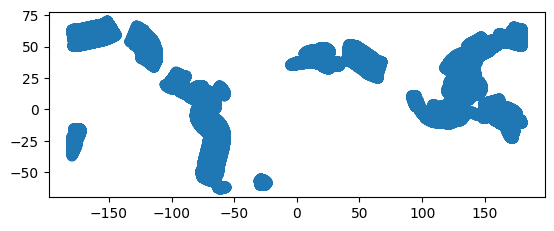

In [251]:
points_gdf.plot()

In [181]:
columns

Index(['Latitude a_left', 'Longitude a_left', 'z_left', 'geometry',
       'index_right0', 'index', 'Latitude a_right', 'Longitude a_right',
       'z_right', 'Humid_Belt', 'Convergence Rate', 'Migration Rate',
       'Subduction Velocity', 'Obliquity Angle', 'Subduction Normal Angle',
       'Subduction Length', 'Subduction Plate Velocity',
       'Subduction Plate Obliquity', 'vratio', 'Nearest Trench Edge',
       'Start Edge Trench', 'Convergence Velocity Orthogonal',
       'Convergence Velocity Parallel', 'Trench Velocity Orthogonal',
       'Trench Velocity Parallel', 'Subducting Velocity Orthogonal',
       'Subducting Velocity Parallel', 'Subduction Volume Rate',
       'Plate Thickness', 'Subduction Flux', 'Time', 'Trench Distance', 'Dist',
       'Latitude', 'Longitude', 'Mantle_Temp_16', 'Mantle_Temp_31',
       'Mantle_Temp_47', 'Mantle_Temp_62', 'Mantle_Temp_140',
       'Mantle_Temp_155', 'Mantle_Temp_171', 'Mantle_Temp_186',
       'Mantle_Temp_202', 'Mantle_Temp_217', 

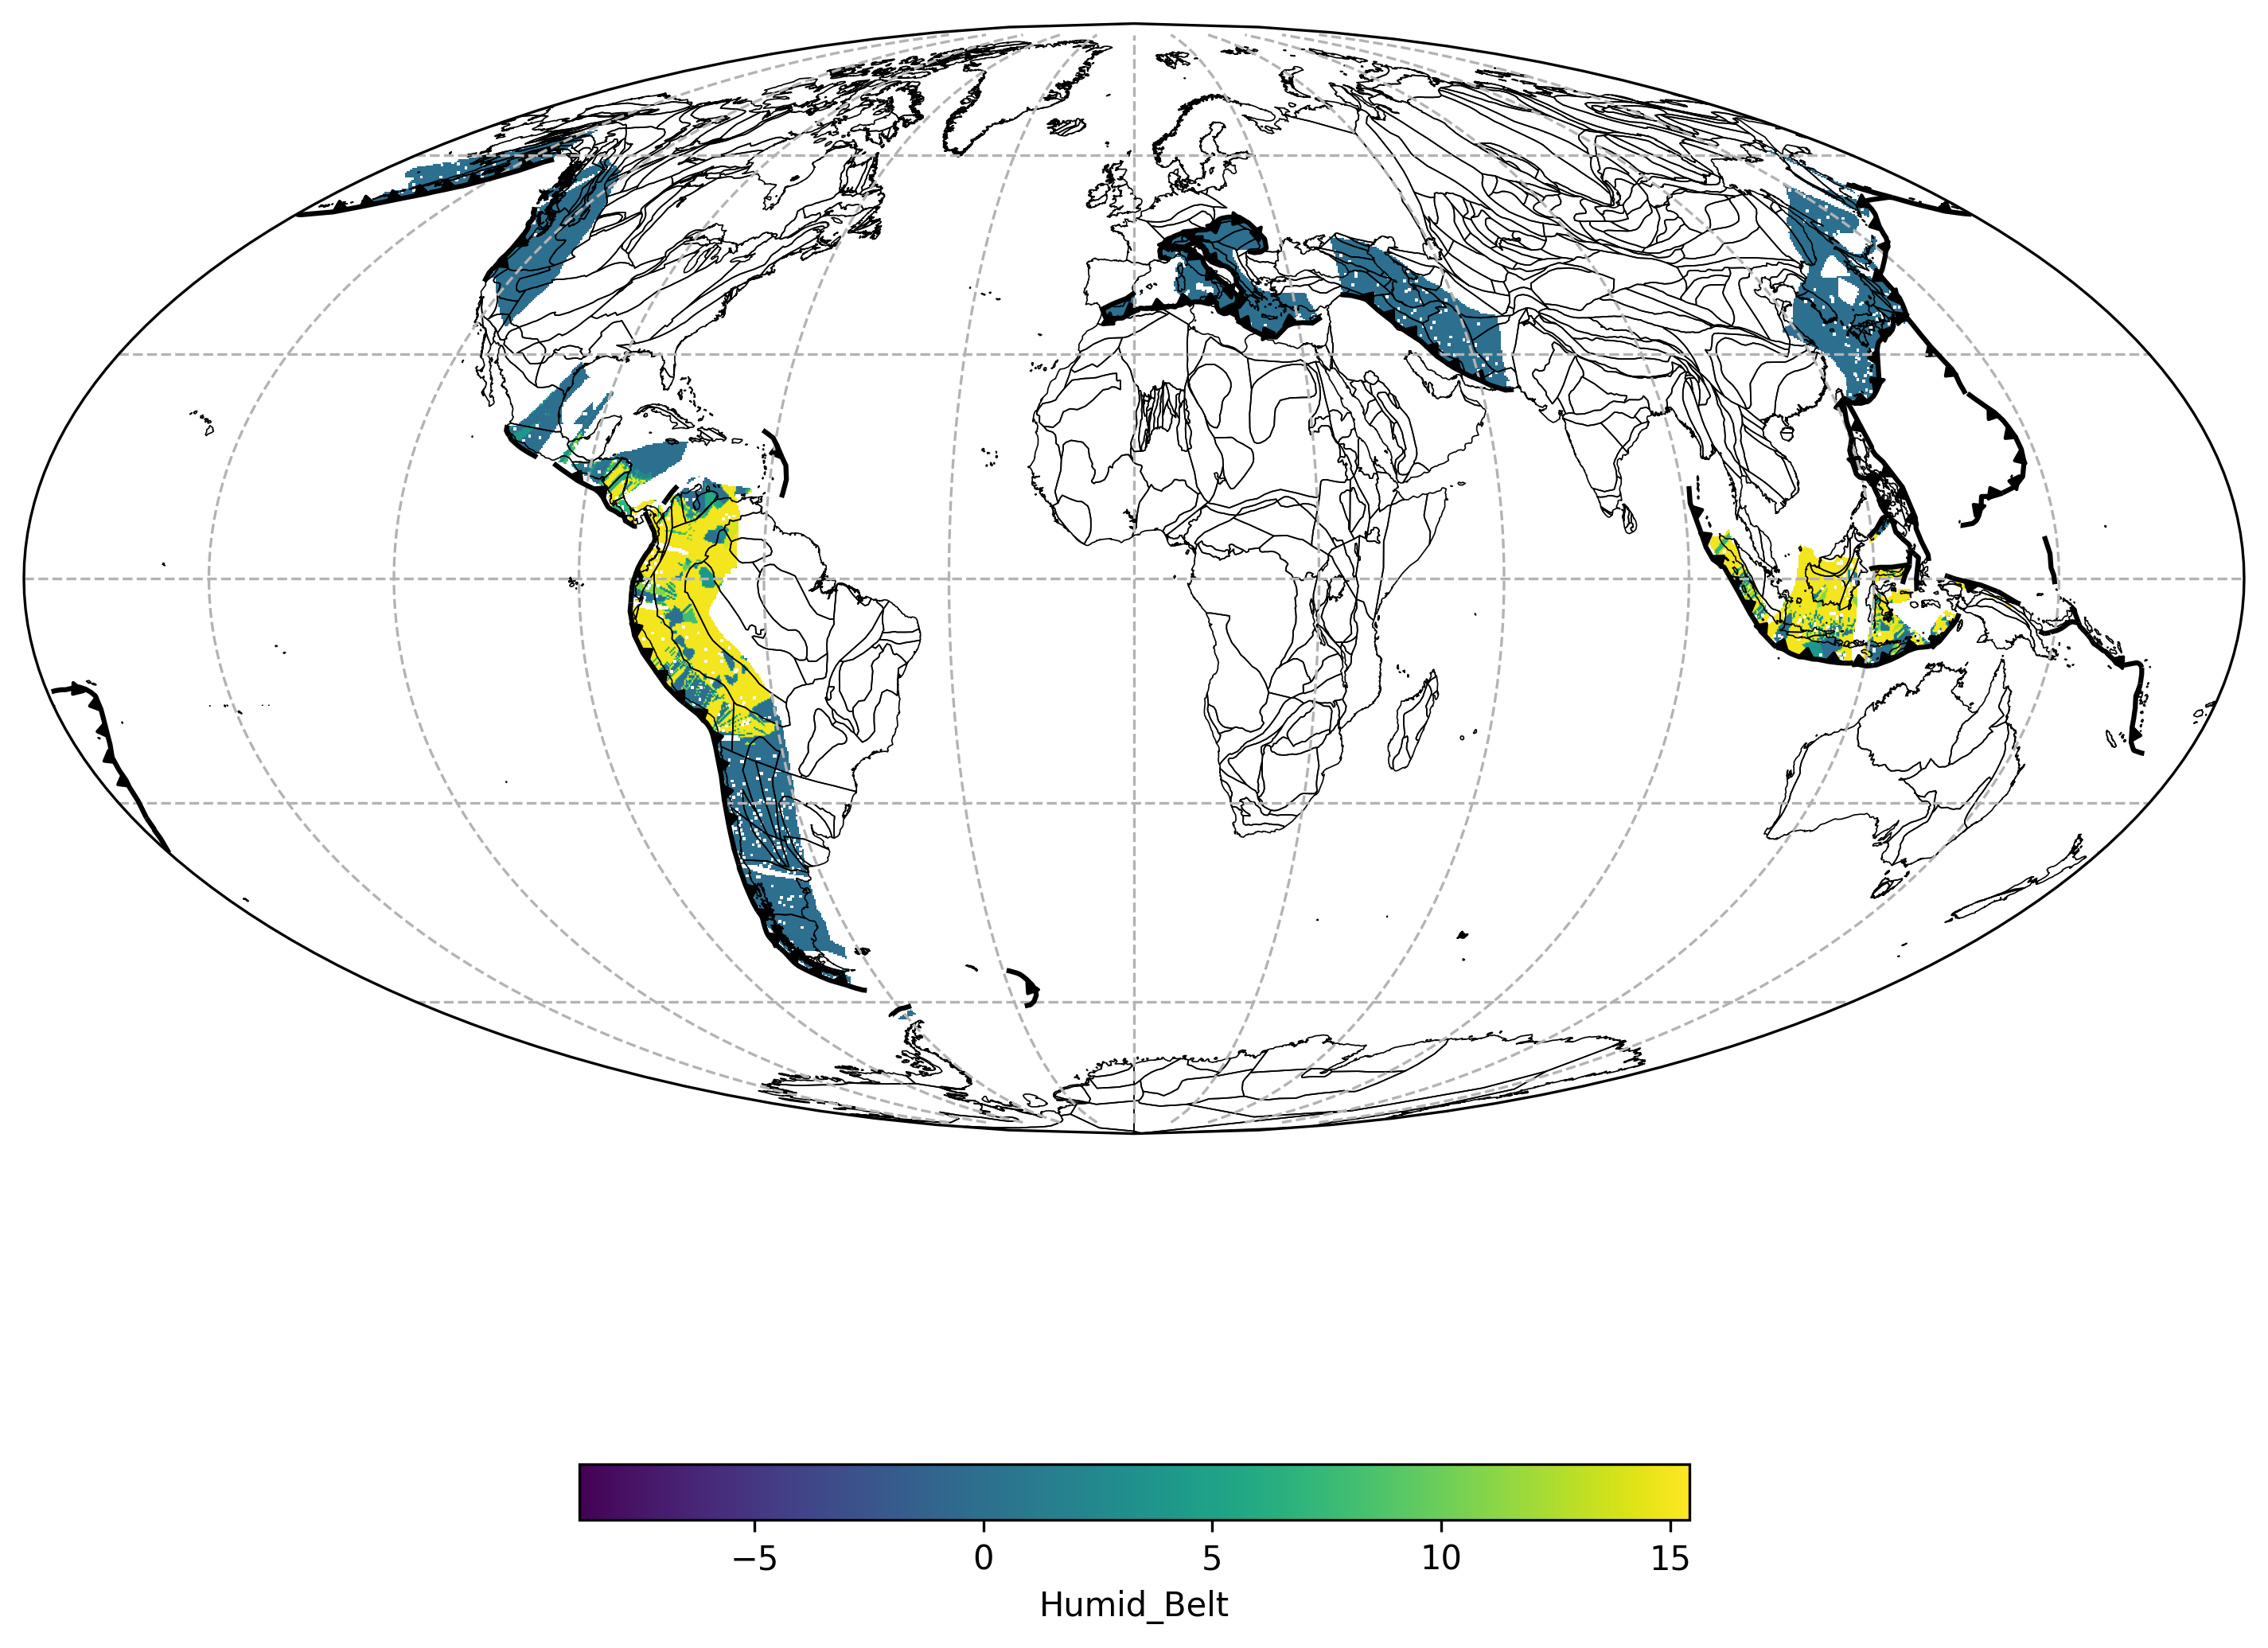

In [183]:
Data_gdf=gpd.GeoDataFrame(point_within_continentsc,geometry=gpd.points_from_xy(point_within_continentsc['Longitude'],point_within_continentsc['Latitude']))
# Data_gdf=gpd.GeoDataFrame(TrainingData,geometry=gpd.points_from_xy(TrainingData['Longitude'],TrainingData['Latitude']))

## Quick Plot
figsize=[12,12]
central_longitude=0
fig = plt.figure(figsize=figsize, dpi=300)    
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = central_longitude))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))

mollweide_proj = f"+proj=moll +lon_0={central_longitude} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
        
columns=Data_gdf.columns
column=columns[9]
gplot.plot_coastlines(ax=ax,color='none', edgecolor="black",linewidth=0.4)
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax=ax,color='k')
da=df_to_NetCDF(x=Data_gdf["Longitude"],y=Data_gdf["Latitude"],z=Data_gdf[column])
ds=da.to_dataset(name=column)
data = Data_gdf[column]

# Calculate mean and standard deviation
mean = data.mean()
std = data.std()

# Calculate vmin and vmax
vmin = mean - 2 * std
vmax = mean + 2 * std
kwargs={'vmin':vmin,'vmax':vmax}
k=gplot.plot_grid(ax=ax, grid=da,**kwargs)
# c=fig.colorbar(k, cax=ax)
ds[column].plot(ax=ax,vmin=vmin,vmax=vmax, cbar_kwargs={'orientation':'horizontal','shrink':0.5,
                                          'label':f'{column}'})


In [72]:
# del TrainingData
print(f"Number of Data Points:{len(Data_gdf)}")

Number of Data Points:275174


In [158]:
columns_to_train=['Humid_Belt', 
                  'Convergence Rate', 
                  'Migration Rate',
       'Subduction Velocity', 
                  # 'Obliquity Angle', 'Subduction Normal Angle',
       'Subduction Length', 
                  'Subduction Plate Velocity',
       'Subduction Plate Obliquity', 
                  # 'Nearest Trench Edge',
       #   'Convergence Velocity Orthogonal',
       # 'Convergence Velocity Parallel', 'Trench Velocity Orthogonal',
       # 'Trench Velocity Parallel', 'Subducting Velocity Orthogonal',
       # 'Subducting Velocity Parallel',
                  'Subduction Volume Rate',
       'Plate Thickness',
                  'Subduction Flux', 
                  'Trench Distance',
        'Mantle_Temp_16', 'Mantle_Temp_31',
       'Mantle_Temp_47', 'Mantle_Temp_62', 'Mantle_Temp_140',
       'Mantle_Temp_155', 'Mantle_Temp_171', 'Mantle_Temp_186',
       'Mantle_Temp_202', 'Mantle_Temp_217', 'Mantle_Temp_233',
       'Mantle_Temp_268', 'Mantle_Temp_293', 'Mantle_Temp_323',
       'Mantle_Temp_357', 'Mantle_Temp_396', 'Mantle_Temp_439',
       'Mantle_Temp_487', 'Mantle_Temp_540', 'Mantle_Temp_597',
       'Mantle_Temp_660',
                  'Mantle_Velocity_16', 'Mantle_Velocity_31',
       'Mantle_Velocity_47', 'Mantle_Velocity_62', 'Mantle_Velocity_140',
       'Mantle_Velocity_155', 'Mantle_Velocity_171', 'Mantle_Velocity_186',
       'Mantle_Velocity_202', 
                  'Mantle_Velocity_217', 'Mantle_Velocity_233',
       'Mantle_Velocity_268', 'Mantle_Velocity_293', 'Mantle_Velocity_323',
       'Mantle_Velocity_357', 'Mantle_Velocity_396', 'Mantle_Velocity_439',
       'Mantle_Velocity_487', 'Mantle_Velocity_540', 'Mantle_Velocity_597',
       'Mantle_Velocity_660']

In [164]:
# point_within_mountains

Empty GeoDataFrame
Columns: [Latitude a_left, Longitude a_left, z_left, geometry, index_right0, index, Latitude a_right, Longitude a_right, z_right, Humid_Belt, Convergence Rate, Migration Rate, Subduction Velocity, Obliquity Angle, Subduction Normal Angle, Subduction Length, Subduction Plate Velocity, Subduction Plate Obliquity, vratio, Nearest Trench Edge, Start Edge Trench, Convergence Velocity Orthogonal, Convergence Velocity Parallel, Trench Velocity Orthogonal, Trench Velocity Parallel, Subducting Velocity Orthogonal, Subducting Velocity Parallel, Subduction Volume Rate, Plate Thickness, Subduction Flux, Time, Trench Distance, Dist, Latitude, Longitude, Mantle_Temp_16, Mantle_Temp_31, Mantle_Temp_47, Mantle_Temp_62, Mantle_Temp_140, Mantle_Temp_155, Mantle_Temp_171, Mantle_Temp_186, Mantle_Temp_202, Mantle_Temp_217, Mantle_Temp_233, Mantle_Temp_268, Mantle_Temp_293, Mantle_Temp_323, Mantle_Temp_357, Mantle_Temp_396, Mantle_Temp_439, Mantle_Temp_487, Mantle_Temp_540, Mantle_Temp_597, Mantle_Temp_660, Mantle_Velocity_16, Mantle_Velocity_31, Mantle_Velocity_47, Mantle_Velocity_62, Mantle_Velocity_140, Mantle_Velocity_155, Mantle_Velocity_171, Mantle_Velocity_186, Mantle_Velocity_202, Mantle_Velocity_217, Mantle_Velocity_233, Mantle_Velocity_268, Mantle_Velocity_293, Mantle_Velocity_323, Mantle_Velocity_357, Mantle_Velocity_396, Mantle_Velocity_439, Mantle_Velocity_487, Mantle_Velocity_540, Mantle_Velocity_597, Mantle_Velocity_660, DistHB, Trench Longitude, Trench Latitude, dist, Elevation, index_right, GMBA_V2_ID, GMBA_V1_ID, MapName, WikiDataUR, MapUnit, Hier_Lvl, Feature, Area, Perimeter, Elev_Low, Elev_High, Path, Path_ID, Level_01, Level_02, Level_03, Level_04, ...]
Index: []

[0 rows x 123 columns]

## Random Forest Model

In [339]:
RFTopoModel_continents=RFModel(training_df=point_within_continentsc,
            training_variables=columns_to_train, 
            target_variable='Elevation',
            n_estimators=200,
            max_depth=8,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            parallel=10,
            random_state=22)
# RFTopoModel_continents=RFModel(training_df=TrainingData,
#             training_variables=columns_to_train, 
#             target_variable='Elevation',
#             n_estimators=100,
#             max_depth=9,
#             min_samples_split=10,
#             min_samples_leaf=5,
#             max_features='sqrt',
#             parallel=10,
#             random_state=22)


# RFTopoModel_continents=RFModel(training_df=point_within_mountains,
#             training_variables=columns_to_train, 
#             target_variable='Elevation',
#             n_estimators=100,
#             max_depth=9,
#             min_samples_split=10,
#             min_samples_leaf=5,
#             max_features='sqrt',
#             parallel=10,
#             random_state=22)
RFTopoModel_continents.fit()
print(f"Error={abs(RFTopoModel_continents.df['Predicted Elevation']-RFTopoModel_continents.df['Elevation']).mean()} m")



Creating RFTimeTopo model based on parameters:
Humid_Belt
Convergence Rate
Migration Rate
Subduction Velocity
Subduction Length
Subduction Plate Velocity
Subduction Plate Obliquity
Subduction Volume Rate
Plate Thickness
Subduction Flux
Trench Distance
Mantle_Temp_16
Mantle_Temp_31
Mantle_Temp_47
Mantle_Temp_62
Mantle_Temp_140
Mantle_Temp_155
Mantle_Temp_171
Mantle_Temp_186
Mantle_Temp_202
Mantle_Temp_217
Mantle_Temp_233
Mantle_Temp_268
Mantle_Temp_293
Mantle_Temp_323
Mantle_Temp_357
Mantle_Temp_396
Mantle_Temp_439
Mantle_Temp_487
Mantle_Temp_540
Mantle_Temp_597
Mantle_Temp_660
Mantle_Velocity_16
Mantle_Velocity_31
Mantle_Velocity_47
Mantle_Velocity_62
Mantle_Velocity_140
Mantle_Velocity_155
Mantle_Velocity_171
Mantle_Velocity_186
Mantle_Velocity_202
Mantle_Velocity_217
Mantle_Velocity_233
Mantle_Velocity_268
Mantle_Velocity_293
Mantle_Velocity_323
Mantle_Velocity_357
Mantle_Velocity_396
Mantle_Velocity_439
Mantle_Velocity_487
Mantle_Velocity_540
Mantle_Velocity_597
Mantle_Velocity_660


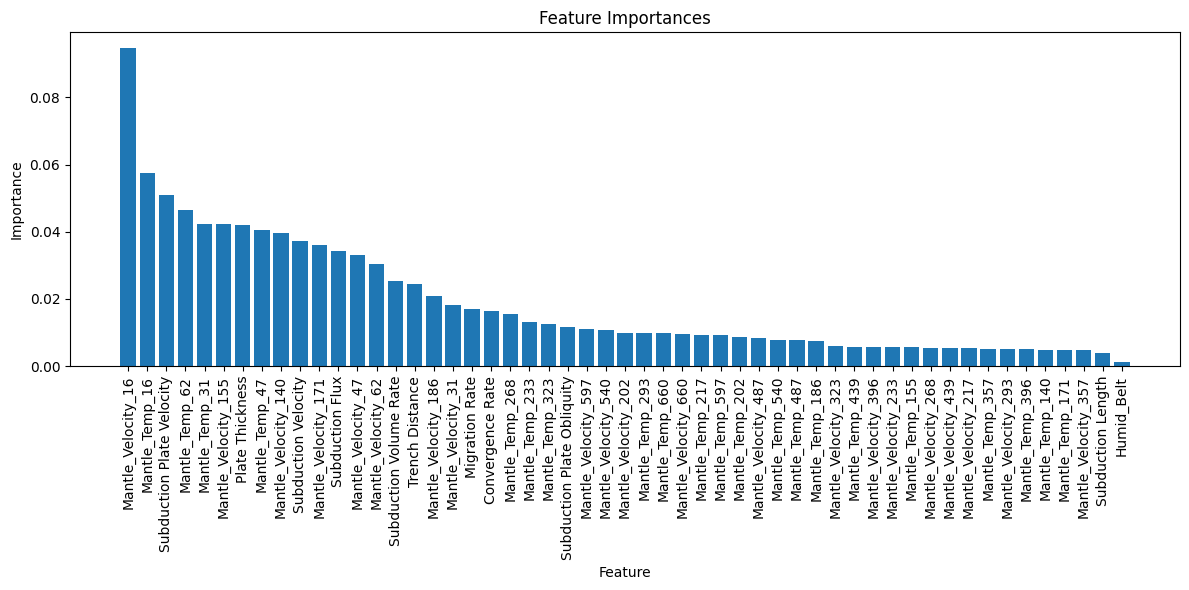

In [340]:
RFTopoModel_continents.plot_feature_importance()

<Axes: >

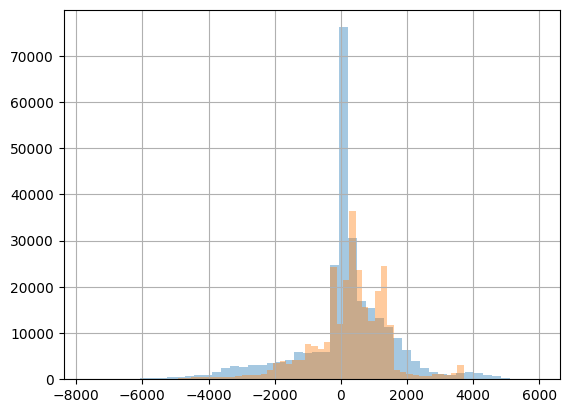

In [341]:
RFTopoModel_continents.df['Elevation'].hist(bins=50,alpha=0.4)
RFTopoModel_continents.df['Predicted Elevation'].hist(bins=50,alpha=0.4)

In [321]:
RFTopoModel_continents.df['Predicted Elevation'].max()

3918.8083159887847

In [177]:
create_directory_if_not_exists(f"{OUTPUT_FOLDER}/Models/Best_Models/RF_Model")
RFTopoModel_continents.save_model(f"{OUTPUT_FOLDER}/Models/Best_Models/RF_Model")

Saved DataFrame, model, and columns to Paleotopography/Models/Best_Models/RF_Model


## Deep Learning Model

In [178]:
point_within_continentsc.columns

Index(['Latitude a_left', 'Longitude a_left', 'z_left', 'geometry',
       'index_right0', 'index', 'Latitude a_right', 'Longitude a_right',
       'z_right', 'Humid_Belt', 'Convergence Rate', 'Migration Rate',
       'Subduction Velocity', 'Obliquity Angle', 'Subduction Normal Angle',
       'Subduction Length', 'Subduction Plate Velocity',
       'Subduction Plate Obliquity', 'vratio', 'Nearest Trench Edge',
       'Start Edge Trench', 'Convergence Velocity Orthogonal',
       'Convergence Velocity Parallel', 'Trench Velocity Orthogonal',
       'Trench Velocity Parallel', 'Subducting Velocity Orthogonal',
       'Subducting Velocity Parallel', 'Subduction Volume Rate',
       'Plate Thickness', 'Subduction Flux', 'Time', 'Trench Distance', 'Dist',
       'Latitude', 'Longitude', 'Mantle_Temp_16', 'Mantle_Temp_31',
       'Mantle_Temp_47', 'Mantle_Temp_62', 'Mantle_Temp_140',
       'Mantle_Temp_155', 'Mantle_Temp_171', 'Mantle_Temp_186',
       'Mantle_Temp_202', 'Mantle_Temp_217', 

In [358]:
DLTopoModel_continents=DLModel(training_df=point_within_continentsc,
                               training_variables=columns_to_train,
                               target_variable='Elevation',
                               nodes=16, 
                               n_epoch=20, 
                               dropout=0.1, 
                               bn=True, 
                               lr="OnPlateau", 
                               scaler="RobustScaler")

# DLTopoModel_continents=DLModel(training_df=TrainingData,
#                                training_variables=columns_to_train,
#                                target_variable='Elevation',
#                                nodes=16, 
#                                n_epoch=10, 
#                                dropout=0.4, 
#                                bn=True, 
#                                lr="OnPlateau", 
#                                scaler="StandardScaler")
DLTopoModel_continents.fit()
print(f"Error={abs(DLTopoModel_continents.df['Predicted Elevation']-DLTopoModel_continents.df['Elevation']).mean()} m")

Creating RFTimeTopo model based on parameters:
Humid_Belt
Convergence Rate
Migration Rate
Subduction Velocity
Subduction Length
Subduction Plate Velocity
Subduction Plate Obliquity
Subduction Volume Rate
Plate Thickness
Subduction Flux
Trench Distance
Mantle_Temp_16
Mantle_Temp_31
Mantle_Temp_47
Mantle_Temp_62
Mantle_Temp_140
Mantle_Temp_155
Mantle_Temp_171
Mantle_Temp_186
Mantle_Temp_202
Mantle_Temp_217
Mantle_Temp_233
Mantle_Temp_268
Mantle_Temp_293
Mantle_Temp_323
Mantle_Temp_357
Mantle_Temp_396
Mantle_Temp_439
Mantle_Temp_487
Mantle_Temp_540
Mantle_Temp_597
Mantle_Temp_660
Mantle_Velocity_16
Mantle_Velocity_31
Mantle_Velocity_47
Mantle_Velocity_62
Mantle_Velocity_140
Mantle_Velocity_155
Mantle_Velocity_171
Mantle_Velocity_186
Mantle_Velocity_202
Mantle_Velocity_217
Mantle_Velocity_233
Mantle_Velocity_268
Mantle_Velocity_293
Mantle_Velocity_323
Mantle_Velocity_357
Mantle_Velocity_396
Mantle_Velocity_439
Mantle_Velocity_487
Mantle_Velocity_540
Mantle_Velocity_597
Mantle_Velocity_660


In [360]:
# DLTopoModel_continents.scaler2.mean_

In [361]:
DLTopoModel_continents.scaler2.scale_

array([910.31139755])

In [362]:
# DLTopoModel_continents.df['Predicted Elevation']=DLTopoModel_continents.df['Predicted Elevation']+50

<Axes: >

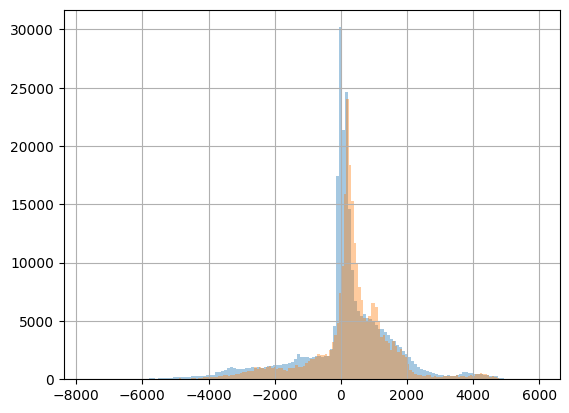

In [363]:
DLTopoModel_continents.df['Elevation'].hist(bins=150,alpha=0.4)
DLTopoModel_continents.df['Predicted Elevation'].hist(bins=150,alpha=0.4)

In [364]:
DLTopoModel_continents.df['Predicted Elevation'].max()

5227.45

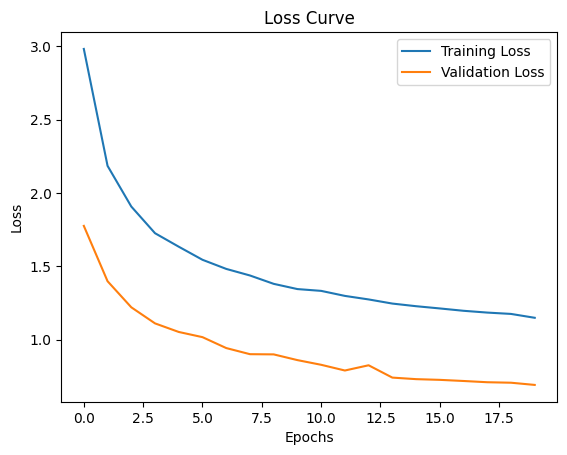

In [365]:
DLTopoModel_continents.plot_loss_curve()

In [95]:
create_directory_if_not_exists(f"{OUTPUT_FOLDER}/Models/Best_Models/DL_Model")
DLTopoModel_continents.save_model(f"{OUTPUT_FOLDER}/Models/Best_Models/DL_Model")

Created directory: Paleotopography/Models/Best_Models/DL_Model
Saved model components to Paleotopography/Models/Best_Models/DL_Model


Creating RFTimeTopo model based on parameters:
Humid_Belt
Convergence Rate
Migration Rate
Subduction Velocity
Subduction Length
Subduction Plate Velocity
Subduction Plate Obliquity
Subduction Volume Rate
Plate Thickness
Subduction Flux
Trench Distance
Mantle_Temp_16
Mantle_Temp_31
Mantle_Temp_47
Mantle_Temp_62
Mantle_Temp_140
Mantle_Temp_155
Mantle_Temp_171
Mantle_Temp_186
Mantle_Temp_202
Mantle_Temp_217
Mantle_Temp_233
Mantle_Temp_268
Mantle_Temp_293
Mantle_Temp_323
Mantle_Temp_357
Mantle_Temp_396
Mantle_Temp_439
Mantle_Temp_487
Mantle_Temp_540
Mantle_Temp_597
Mantle_Temp_660
Mantle_Velocity_16
Mantle_Velocity_31
Mantle_Velocity_47
Mantle_Velocity_62
Mantle_Velocity_140
Mantle_Velocity_155
Mantle_Velocity_171
Mantle_Velocity_186
Mantle_Velocity_202
Mantle_Velocity_217
Mantle_Velocity_233
Mantle_Velocity_268
Mantle_Velocity_293
Mantle_Velocity_323
Mantle_Velocity_357
Mantle_Velocity_396
Mantle_Velocity_439
Mantle_Velocity_487
Mantle_Velocity_540
Mantle_Velocity_597
Mantle_Velocity_660


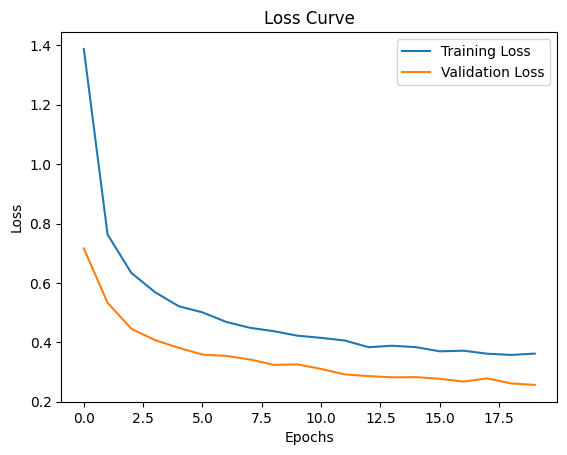

In [366]:
DLTopoModel_mountains=DLModel(training_df=point_within_mountains,
                              training_variables=columns_to_train,
                              target_variable='Elevation',
                               nodes=8, 
                               n_epoch=20, 
                               dropout=0.01, 
                               bn=True, 
                               lr="OnPlateau", 
                               scaler="RobustScaler")
DLTopoModel_mountains.fit()
DLTopoModel_mountains.plot_loss_curve()

<Axes: >

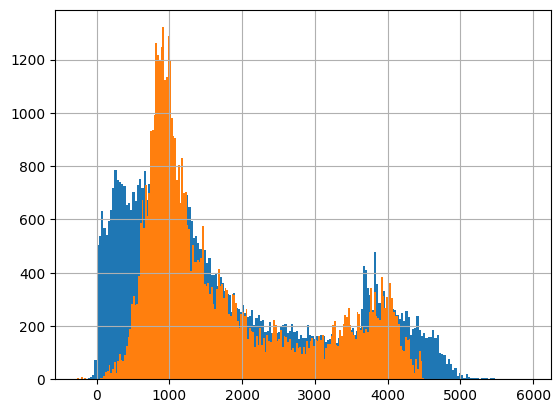

In [367]:
DLTopoModel_mountains.df['Elevation'].hist(bins=200)
DLTopoModel_mountains.df['Predicted Elevation'].hist(bins=200)

In [99]:
create_directory_if_not_exists(f"{OUTPUT_FOLDER}/Models/Best_Models/DL_Model_Mountains")
DLTopoModel_mountains.save_model(f"{OUTPUT_FOLDER}/Models/Best_Models/DL_Model_Mountains")

Created directory: Paleotopography/Models/Best_Models/DL_Model_Mountains
Saved model components to Paleotopography/Models/Best_Models/DL_Model_Mountains


Index(['Latitude a_left', 'Longitude a_left', 'z_left', 'geometry',
       'index_right0', 'index', 'Latitude a_right', 'Longitude a_right',
       'z_right', 'Humid_Belt', 'Convergence Rate', 'Migration Rate',
       'Subduction Velocity', 'Obliquity Angle', 'Subduction Normal Angle',
       'Subduction Length', 'Subduction Plate Velocity',
       'Subduction Plate Obliquity', 'vratio', 'Nearest Trench Edge',
       'Start Edge Trench', 'Convergence Velocity Orthogonal',
       'Convergence Velocity Parallel', 'Trench Velocity Orthogonal',
       'Trench Velocity Parallel', 'Subducting Velocity Orthogonal',
       'Subducting Velocity Parallel', 'Subduction Volume Rate',
       'Plate Thickness', 'Subduction Flux', 'Time', 'Trench Distance', 'Dist',
       'Latitude', 'Longitude', 'Mantle_Temp_16', 'Mantle_Temp_31',
       'Mantle_Temp_47', 'Mantle_Temp_62', 'Mantle_Temp_140',
       'Mantle_Temp_155', 'Mantle_Temp_171', 'Mantle_Temp_186',
       'Mantle_Temp_202', 'Mantle_Temp_217', 

In [435]:
columns_to_train2=['Humid_Belt', 
                  'Convergence Rate', 
                  'Migration Rate',
       # 'Subduction Velocity', 
                  # 'Obliquity Angle', 'Subduction Normal Angle',
       'Subduction Length', 
                  # 'Subduction Plate Velocity',
       'Subduction Plate Obliquity', 
                  # 'Nearest Trench Edge',
       #   'Convergence Velocity Orthogonal',
       # 'Convergence Velocity Parallel', 'Trench Velocity Orthogonal',
       # 'Trench Velocity Parallel', 'Subducting Velocity Orthogonal',
       # 'Subducting Velocity Parallel',
                  # 'Subduction Volume Rate',
       'Plate Thickness',
                  # 'Subduction Flux', 
                  'Trench Distance',
        'Mantle_Temp_16', 'Mantle_Temp_31',
       'Mantle_Temp_47', 'Mantle_Temp_62', 'Mantle_Temp_140',
       'Mantle_Temp_155', 'Mantle_Temp_171', 'Mantle_Temp_186',
       'Mantle_Temp_202', 'Mantle_Temp_217', 'Mantle_Temp_233',
       'Mantle_Temp_268', 'Mantle_Temp_293', 'Mantle_Temp_323',
       'Mantle_Temp_357', 'Mantle_Temp_396', 'Mantle_Temp_439',
       'Mantle_Temp_487', 'Mantle_Temp_540', 'Mantle_Temp_597',
       'Mantle_Temp_660',
                  'Mantle_Velocity_16', 'Mantle_Velocity_31',
       'Mantle_Velocity_47', 'Mantle_Velocity_62', 'Mantle_Velocity_140',
       'Mantle_Velocity_155', 'Mantle_Velocity_171', 'Mantle_Velocity_186',
       'Mantle_Velocity_202', 
                  'Mantle_Velocity_217', 'Mantle_Velocity_233',
       'Mantle_Velocity_268', 'Mantle_Velocity_293', 'Mantle_Velocity_323',
       'Mantle_Velocity_357', 'Mantle_Velocity_396', 'Mantle_Velocity_439',
       'Mantle_Velocity_487', 'Mantle_Velocity_540', 'Mantle_Velocity_597',
       'Mantle_Velocity_660']

In [497]:
featuresc=point_within_continentsc.copy()
# featuresc=TrainingData.copy()
# featuresc=featuresc[columns_to_train]
X_train, X_test, y_train, y_test = train_test_split(featuresc[columns_to_train2], featuresc['Elevation'], test_size=0.3, random_state=22)

# interactions=[(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,2),(2,4),(2,5)]
# ebm = ExplainableBoostingRegressor(learning_rate=0.5,
#                                    interactions=None,
#                                    # exclude=[(3)],
#                                    # max_rounds=15000,
#                                    # max_bins=2048,
#                                    # max_interaction_bins=64,
#                                    # max_leaves=6,
#                                    # outer_bags=30,
#                                    # inner_bags=0,
#                                    # smoothing_rounds=500,
#                                    n_jobs=-1)

ebm = ExplainableBoostingRegressor(
    learning_rate=0.05,
    interactions=None,
    outer_bags=20,
    # inner_bags=5,
    max_rounds=500,
    max_leaves=3,
    # max_bins=256,
    # smoothing_rounds=1000,
    n_jobs=-1
)
ebm.fit(X_train, y_train.to_numpy())
# Make predictions on the test set
y_pred = ebm.predict( X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 719.7254316858582


In [486]:
# plt.hist(y_pred,bins=100)

In [487]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/25947993088/ -->

## Predict Elevation

In [106]:
# dfrf_ca, RFmodel_ca, columns_ca=RFTopoModel_continents.load_model(f"{OUTPUT_FOLDER}/Models/Best_Models/RF_Model")
# RFTopoModel_continents.model=RFmodel_ca
# RFTopoModel_continents.df['Predicted Elevation']=RFTopoModel_continents.predict(RFTopoModel_continents.df)
# RFTopoModel_continents.df['Difference']=RFTopoModel_continents.df['Elevation']-RFTopoModel_continents.df['Predicted Elevation']

In [107]:
# DLTopoModel_continents.load_model(f"{OUTPUT_FOLDER}/Models/Best_Models/DL_Model")
# DLTopoModel_mountains.load_model(f"{OUTPUT_FOLDER}/Models/Best_Models/DL_Model_Mountains")

In [489]:
def smooth_weighted_mean(row):
    # predicted_elevation=(row["ElevationDL (Ca)"]+row["ElevationDL (Ca)"])/2
    # predicted_elevation = row['Elevation (All)']
    # elevation_mts = (row['ElevationRF (Mts)']+row['ElevationDL (Mts)'])/2

    predicted_elevation=row["ElevationDLC"]
    # predicted_elevation = row['Elevation (All)']
    elevation_mts = row['ElevationDLM']
    
    
    # Define the smoothing factor (adjust as needed)
    smoothing_factor = 0.001
    
    # Sigmoid-like function to smoothly increase weight of 'Elevation (Mts)'
    weight = 1 / (1 + np.exp(-smoothing_factor * (predicted_elevation -300)))
    
    # Calculate the weighted mean
    weighted_mean_value = (1 - weight) * predicted_elevation + weight * elevation_mts
    
    return weighted_mean_value

In [490]:
# reconstruction_time=0
create_directory_if_not_exists(f'{DEFAULT_OUTPUT_CSV}/Prediction')
def get_ensemble(reconstruction_time,columns_to_train=columns_to_train):
    try:
        print(f"Working on Time={reconstruction_time} Ma")
        Data=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA2/Processed_Data_{reconstruction_time}.parquet")
        Data=Data[Data['Trench Distance']<1400000]
        Data=Data[Data['Trench Distance']>100000].copy()
       
        Data["ElevationRF"]=RFTopoModel_continents.predict(Data)
        Data["ElevationDLC"]=DLTopoModel_continents.predict(Data)
        Data["ElevationDLM"]=DLTopoModel_mountains.predict(Data)
        Data["ElevationEBM"] = ebm.predict(Data[columns_to_train])
        Data['ElevationDL'] = Data.apply(smooth_weighted_mean, axis=1)
        Data['Paleotopography']=(Data["ElevationEBM"]+Data["ElevationRF"])/2
        Data.to_parquet(f'{DEFAULT_OUTPUT_CSV}/Prediction/Predicted_{MODEL_NAME}_{reconstruction_time}Ma.parquet')
    except Exception as e:
        print(f"Missing Data. Skipping Time Steps {reconstruction_time}")
        print(e)
        pass
        
    
    
    print("Saved Prediction!")
    return Data


### Present Day Topography

In [399]:
Data=get_ensemble(0,columns_to_train=columns_to_train)
Data=ETopo.get_parameters(Data)

Working on Time=0 Ma
Saved Prediction!


In [118]:
# Data['Difference'].hist()

In [119]:
print(50*"–")
print("Error of Model")
print(50*"–")
print("Random Forest Model:")
print(20*" –")

print(f'{np.mean(abs(RFTopoModel_continents.df["Difference"]))}')

print(20*" –")
print("Deep Learning Model:")
print(20*" –")

print(f'{np.mean(abs(DLTopoModel_continents.df["Difference"]))}')
Data['Difference']=abs(Data["Elevation"]-Data["Paleotopography"])

print(f"Total: {np.mean(abs(Data['Difference']))}")

# print(50*"–")

––––––––––––––––––––––––––––––––––––––––––––––––––
Error of Model
––––––––––––––––––––––––––––––––––––––––––––––––––
Random Forest Model:
 – – – – – – – – – – – – – – – – – – – –
479.12998301986784
 – – – – – – – – – – – – – – – – – – – –
Deep Learning Model:
 – – – – – – – – – – – – – – – – – – – –
433.0278015136719
Total: 837.7074604816262


In [498]:
Utpal=get_ensemble(70,columns_to_train=columns_to_train2)

Working on Time=70 Ma
Saved Prediction!


In [499]:
# K=

<Axes: >

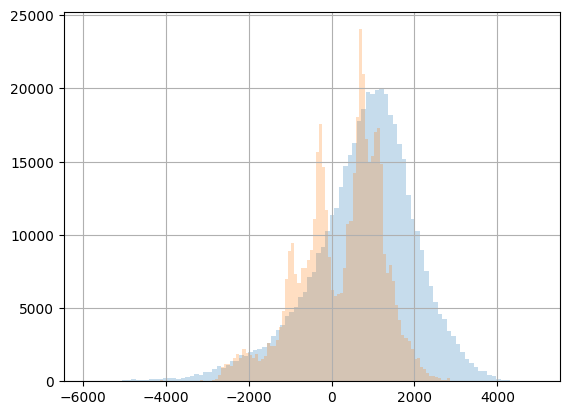

In [500]:
# Utpal["ElevationRF"].hist(bins=1000,alpha=0.5)
Utpal['ElevationEBM'].hist(bins=100,alpha=0.25)
Utpal['ElevationRF'].hist(bins=100,alpha=0.25)
# Utpal['Paleotopography'].hist(bins=20,alpha=0.25)

In [501]:
Utpal['ElevationEBM'].max()

4958.189883218195

In [502]:
Data_gdf=gpd.GeoDataFrame(Utpal,geometry=gpd.points_from_xy(Utpal['Longitude'],Utpal['Latitude']))
# Data_

<GeoAxes: >

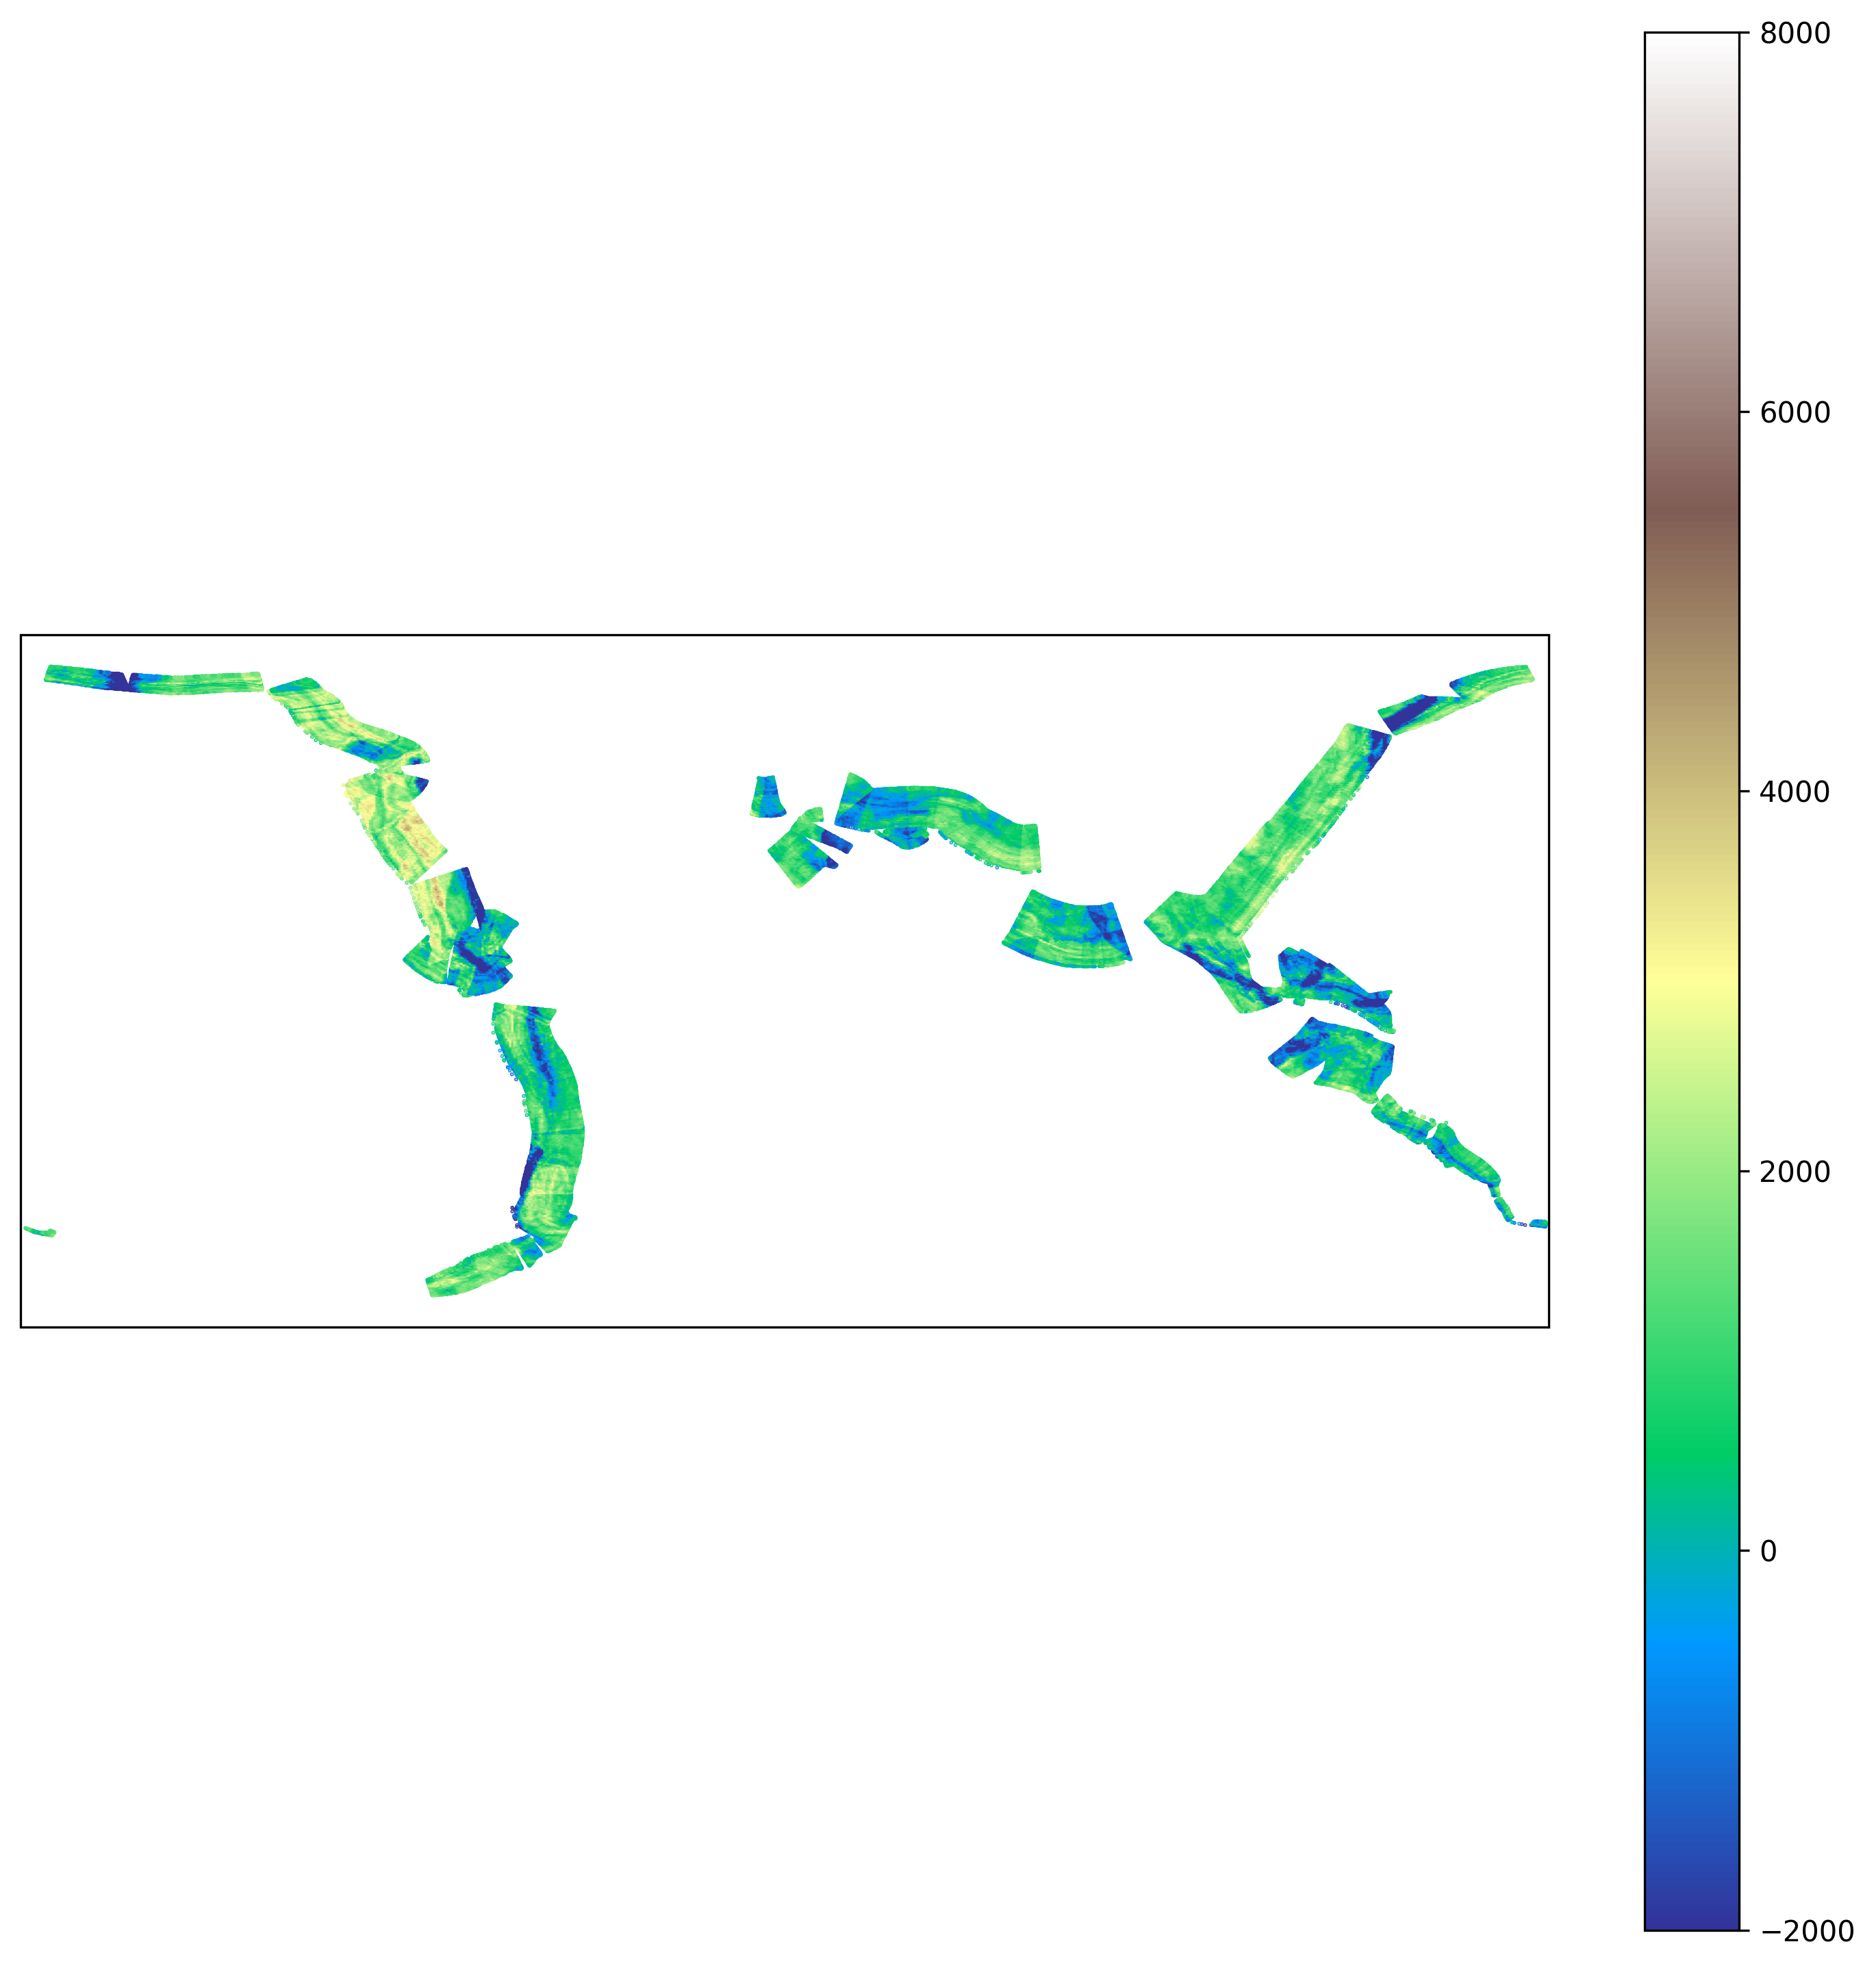

In [503]:
## Quick Plot
figsize=[12,12]
central_longitude=0
fig = plt.figure(figsize=figsize, dpi=300)    
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
Data_gdf.plot(ax=ax,column='ElevationEBM',cmap='terrain',vmin=-2000,vmax=8000,markersize=0.1,legend=True)

## Prediction

In [504]:
for reconstruction_time in all_times:
    # if reconstruction_time<183:
    #     continue
    Dataf=get_ensemble(reconstruction_time)

Working on Time=0 Ma
Saved Prediction!
Working on Time=1 Ma
Saved Prediction!
Working on Time=2 Ma
Saved Prediction!
Working on Time=3 Ma
Saved Prediction!
Working on Time=4 Ma
Saved Prediction!
Working on Time=5 Ma
Saved Prediction!
Working on Time=6 Ma
Saved Prediction!
Working on Time=7 Ma
Saved Prediction!
Working on Time=8 Ma
Saved Prediction!
Working on Time=9 Ma
Saved Prediction!
Working on Time=10 Ma
Saved Prediction!
Working on Time=11 Ma
Saved Prediction!
Working on Time=12 Ma
Saved Prediction!
Working on Time=13 Ma
Saved Prediction!
Working on Time=14 Ma
Saved Prediction!
Working on Time=15 Ma
Saved Prediction!
Working on Time=16 Ma
Saved Prediction!
Working on Time=17 Ma
Saved Prediction!
Working on Time=18 Ma
Saved Prediction!
Working on Time=19 Ma
Saved Prediction!
Working on Time=20 Ma
Saved Prediction!
Working on Time=21 Ma
Saved Prediction!
Working on Time=22 Ma
Saved Prediction!
Working on Time=23 Ma
Saved Prediction!
Working on Time=24 Ma
Saved Prediction!
Working on

## Random Forest Model

In [66]:
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_NetCDF}/RF_Model")
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_NetCDF}/DL_Model")
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_NetCDF}/DLC_Model")
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_NetCDF}/Ensemble_Model")
compression = {'zlib': ZLIB, 'complevel': COMPLEVEL}
for reconstruction_time in all_times:
    # if reconstruction_time>=508:
    #     continue
    # try:
    print(f"Working on Time={reconstruction_time} Ma")
    Data=pd.read_parquet(f'{DEFAULT_OUTPUT_CSV}/Prediction/Predicted_{MODEL_NAME}_{reconstruction_time}Ma.parquet')
    column_for_netcdf1="ElevationRF"

    if compression:
        encoding = {column_for_netcdf1: compression}
    else:
        encoding = None
    
    da = df_to_NetCDF(x=Data['Longitude'], y=Data['Latitude'], z=Data[column_for_netcdf1], statistic='mean', grid_resolution=0.1, clip=(None, None))
    ds=da.to_dataset(name=column_for_netcdf1)
    ds.to_netcdf(f'{DEFAULT_OUTPUT_NetCDF}/RF_Model/RF_Model_{MODEL_NAME}_{reconstruction_time}.nc',encoding=encoding)
    
    column_for_netcdf2="ElevationDLC"
   
    if compression:
        encoding = {column_for_netcdf2: compression}
    else:
        encoding = None
    
    da = df_to_NetCDF(x=Data['Longitude'], y=Data['Latitude'], z=Data[column_for_netcdf2], statistic='mean', grid_resolution=0.1, clip=(None, None))
    ds=da.to_dataset(name=column_for_netcdf2)
    ds.to_netcdf(f'{DEFAULT_OUTPUT_NetCDF}/DLC_Model/DLC_Model_{MODEL_NAME}_{reconstruction_time}.nc',encoding=encoding)

    
    
    
    column_for_netcdf2="ElevationDL"
   
    if compression:
        encoding = {column_for_netcdf2: compression}
    else:
        encoding = None
    
    da = df_to_NetCDF(x=Data['Longitude'], y=Data['Latitude'], z=Data[column_for_netcdf2], statistic='mean', grid_resolution=0.1, clip=(None, None))
    ds=da.to_dataset(name=column_for_netcdf2)
    ds.to_netcdf(f'{DEFAULT_OUTPUT_NetCDF}/DL_Model/DL_Model_{MODEL_NAME}_{reconstruction_time}.nc',encoding=encoding)

    column_for_netcdf3='Paleotopography'
   
    if compression:
        encoding = {column_for_netcdf3: compression}
    else:
        encoding = None
    
    da = df_to_NetCDF(x=Data['Longitude'], y=Data['Latitude'], z=Data[column_for_netcdf3], statistic='mean', grid_resolution=0.1, clip=(None, None))
    ds=da.to_dataset(name=column_for_netcdf3)
    ds.to_netcdf(f'{DEFAULT_OUTPUT_NetCDF}/Ensemble_Model/Ensemble_Model_{MODEL_NAME}_{reconstruction_time}.nc',encoding=encoding)

    print("Saved NetCDF!")
    # except Exception as e:
    #     print(e)

Created directory: Paleotopography/NetCDF/RF_Model
Created directory: Paleotopography/NetCDF/DL_Model
Created directory: Paleotopography/NetCDF/DLC_Model
Created directory: Paleotopography/NetCDF/Ensemble_Model
Working on Time=0 Ma
Saved NetCDF!
Working on Time=3 Ma
Saved NetCDF!
Working on Time=6 Ma
Saved NetCDF!
Working on Time=9 Ma
Saved NetCDF!
Working on Time=12 Ma
Saved NetCDF!
Working on Time=15 Ma
Saved NetCDF!
Working on Time=18 Ma
Saved NetCDF!
Working on Time=21 Ma
Saved NetCDF!
Working on Time=24 Ma
Saved NetCDF!
Working on Time=27 Ma
Saved NetCDF!
Working on Time=30 Ma
Saved NetCDF!
Working on Time=33 Ma
Saved NetCDF!
Working on Time=36 Ma
Saved NetCDF!
Working on Time=39 Ma
Saved NetCDF!
Working on Time=42 Ma
Saved NetCDF!
Working on Time=45 Ma
Saved NetCDF!
Working on Time=48 Ma
Saved NetCDF!
Working on Time=51 Ma
Saved NetCDF!
Working on Time=54 Ma
Saved NetCDF!
Working on Time=57 Ma
Saved NetCDF!
Working on Time=60 Ma
Saved NetCDF!
Working on Time=63 Ma
Saved NetCDF!
W

In [137]:
import os
import numpy as np
import xarray as xr

def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def interpolate_and_save_as_nc(start_time, end_time, required_time_step=1):
    initial_time_step = int(end_time - start_time)
    
    try:
        # Open the NetCDF files with xarray
        src_start = xr.open_dataset(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/NetCDF/ENSEMBLE/ENSEMBLE_Model_phase2_{start_time}.nc")
        src_end = xr.open_dataset(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/NetCDF/ENSEMBLE/ENSEMBLE_Model_phase2_{end_time}.nc")

        # Get the data variable name (replace 'ElevationRF (Ca)' with the actual data variable name if different)
        data_variable_name = 'Paleotopography'  # Ensure this matches the variable name in your files
        start_data = src_start[data_variable_name]
        end_data = src_end[data_variable_name]

        # Extract lat/lon variables
        latitudes = src_start['Latitude']
        longitudes = src_start['Longitude']

        # Define the interpolation time steps
        time_steps = range(1, initial_time_step, required_time_step)

        for time in time_steps:
            # Calculate the interpolated data using your formula
            time_fraction = time / float(initial_time_step)
            interpolated_data = start_data + (end_data - start_data) * time_fraction

            # Prepare NetCDF parameters
            output_nc = f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/NetCDF/ENSEMBLE/ENSEMBLE_Model_phase2_{start_time+time}.nc"
            create_directory_if_not_exists(os.path.dirname(output_nc))
            
            # Create a new xarray Dataset for the interpolated data
            ds_interpolated = xr.Dataset(
                {
                    data_variable_name: (['Latitude', 'Longitude'], interpolated_data.values),
                },
                coords={
                    'Latitude': latitudes,
                    'Longitude': longitudes,
                }
            )
            
            # Copy attributes from source files
            ds_interpolated.attrs.update(src_start.attrs)
            ds_interpolated[data_variable_name].attrs.update(src_start[data_variable_name].attrs)
            
            # Save to NetCDF with compression
            ds_interpolated.to_netcdf(output_nc, mode='w', engine='netcdf4', format='NETCDF4', encoding={data_variable_name: {'zlib': True, 'complevel': 5}})
            
        print(f"Interpolation completed from {start_time} Ma to {end_time} Ma.")

    except Exception as e:
        print(f"No raster file for interpolating from {start_time} Ma to {end_time} Ma: {e}")

# Example usage:
# i = 10
# all_times = [13, 14, 15]  # Example times, update with your actual time steps
# interpolate_and_save_as_nc(start_time=all_times[i], end_time=all_times[i+1], required_time_step=1)


In [138]:
all_times=glob.glob(f'{DEFAULT_OUTPUT_NetCDF}/ENSEMBLE/ENSEMBLE_Model_{MODEL_NAME}_*.nc')

# all_times=glob.glob(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA3/*")
all_times=np.sort([int(time.split('_')[-1].split('.')[0]) for time in all_times])
for i in range(len(all_times)-1):
    interpolate_and_save_as_nc(start_time=all_times[i], end_time=all_times[i+1], required_time_step=1)

Interpolation completed from 0 Ma to 3 Ma.
Interpolation completed from 3 Ma to 6 Ma.
Interpolation completed from 6 Ma to 9 Ma.
Interpolation completed from 9 Ma to 12 Ma.
Interpolation completed from 12 Ma to 15 Ma.
Interpolation completed from 15 Ma to 18 Ma.
Interpolation completed from 18 Ma to 21 Ma.
Interpolation completed from 21 Ma to 24 Ma.
Interpolation completed from 24 Ma to 27 Ma.
Interpolation completed from 27 Ma to 30 Ma.
Interpolation completed from 30 Ma to 33 Ma.
Interpolation completed from 33 Ma to 36 Ma.
Interpolation completed from 36 Ma to 39 Ma.
Interpolation completed from 39 Ma to 42 Ma.
Interpolation completed from 42 Ma to 45 Ma.
Interpolation completed from 45 Ma to 48 Ma.
Interpolation completed from 48 Ma to 51 Ma.
Interpolation completed from 51 Ma to 54 Ma.
Interpolation completed from 54 Ma to 57 Ma.
Interpolation completed from 57 Ma to 60 Ma.
Interpolation completed from 60 Ma to 63 Ma.
Interpolation completed from 63 Ma to 66 Ma.
Interpolation com

In [542]:
# help(PK.model.tessellate_subduction_zones)

In [23]:
def poly_around_sub(i, subduction_df, n_steps=20,resolution=0.1):
    results = {
        'point_lats':[],
        'point_lons':[],
        'dist':[],
        # 'trench_lats':[],
#         'trench_lons':[]
    }
   
    y1 = subduction_df.iloc[i]['Trench Latitude']
    y2 = subduction_df.iloc[i + 1]['Trench Latitude']
    x1 = subduction_df.iloc[i]['Trench Longitude']
    x2 = subduction_df.iloc[i + 1]['Trench Longitude']

    # dist = calc_dist(x1, y1, x2, y2)
    
    Point1=(x1,y1)
    Point2=(x2,y2)
    lines = LineString([Point1, Point2])
    dist=lines.length

    results['dist'].append(dist)

    # if  subduction_df.iloc[i]['Trench Plate ID']== subduction_df.iloc[i+1]['Trench Plate ID'] and dist <= 5.0:
    if  dist <= 5.0:
        try:

            ilon1=subduction_df.iloc[i]['Intersection Longitude'] 
            ilat1=subduction_df.iloc[i]['Intersection Latitude'] 
    
            ilon2=subduction_df.iloc[i+1]['Intersection Longitude'] 
            ilat2=subduction_df.iloc[i+1]['Intersection Latitude'] 
            
            coords = ((x1, y1), (x2, y2), (ilon2, ilat2), (ilon1, ilat1), (x1, y1))
            polygon = Polygon(coords)
            _, lats, lons = multipoints_from_polygon(polygon, resolution=0.09)
            results['point_lats']=lats
            results['point_lons']=lons

        
        except Exception as e:
            print(e)
            pass        
        
        return results
       
            

In [ ]:
from shapely.geometry import LineString
import time

# a=time.time()

n_steps=20

for reconstruction_time in all_times2[0]:
    print(f"Processing Time {reconstruction_time} Ma")
    subduction_df = PK.get_subductiondf(reconstruction_time,tessellation_threshold_deg=0.7)
    subduction_lines=[]
    normal_angle=[]
    
    for i in range(0, len(subduction_df)-1):
        Point1=(subduction_df.iloc[i]['Trench Longitude'],subduction_df.iloc[i]['Trench Latitude'])
        Point2=(subduction_df.iloc[i+1]['Trench Longitude'],subduction_df.iloc[i+1]['Trench Latitude'])
        lines = LineString([Point1, Point2])
        dist=lines.length
        # if  subduction_df.iloc[i]['Trench Plate ID']== subduction_df.iloc[i+1]['Trench Plate ID'] and dist<50.0:
        if  dist<=5.0:
            subduction_lines.append(lines)
        # else:
        #     subduction_lines.append(np.nan)
            
        
    profiles=[]
    trench_lats=[]
    trench_lons=[]

    for i in range(0, len(subduction_df)-1):
        dlon1 = n_steps * np.sin(np.radians(subduction_df.iloc[i]['Subduction Normal Angle']))
        dlat1 = n_steps * np.cos(np.radians(subduction_df.iloc[i]['Subduction Normal Angle']))
        x1=subduction_df.iloc[i]['Trench Longitude']
        y1=subduction_df.iloc[i]['Trench Latitude']
        ilon1 = x1 + dlon1
        ilat1 = y1+ dlat1
        
        start_point = Point(x1+ 0.01*dlon1, y1+ 0.01*dlat1)
        end_point = Point(ilon1, ilat1)
        profile = LineString([start_point, end_point])
        profiles.append(profile)
        trench_lats.append(y1)
        trench_lons.append(x1) 
        
    intersected_points=[]
    intersected_profiles=[]
    intersected_trench_lats=[]
    intersected_trench_lons=[]
    for i in range(len(profiles)):
        for subduction_line in subduction_lines:
            # try:
            intersection=profiles[i].intersection(subduction_line)
            if intersection.geom_type == 'Point':
                # print(profiles[i])
                intersected_profiles.append(profiles[i])
                intersected_trench_lats.append(trench_lats[i])
                intersected_trench_lons.append(trench_lons[i])
                intersected_points.append(intersection)
                # intersections2.append(intersection)
                
    Intersection_df=gpd.GeoDataFrame()
    Intersection_df['Trench Latitude I']=intersected_trench_lats
    Intersection_df['Trench Longitude I']=intersected_trench_lons
    Intersection_df['Intersection Point']=intersected_points
    Intersection_df['Intersection Profile']=intersected_profiles
    Intersection_df['Intersection Latitude']=Intersection_df['Intersection Point'].apply(lambda p: p.y)
    Intersection_df['Intersection Longitude']=Intersection_df['Intersection Point'].apply(lambda p: p.x)
    Intersection_df=Intersection_df.set_geometry(gpd.points_from_xy(Intersection_df['Trench Longitude I'],Intersection_df['Trench Latitude I']))
    # Perform the spatial join
    result = gpd.sjoin_nearest(subduction_df, Intersection_df, how='left', max_distance=1.0)
    result=result.reset_index()
    # Drop rows with the same index, keeping only the first occurrence
    result = result.drop_duplicates(subset=['index'], keep='first')
    result=result.set_index('index')
    # Alternatively, drop duplicates based on the index column
    # If you want to drop duplicates based on specific columns, replace 'index_left' with the appropriate column names
    
    result ['Intersection Latitude'] = result ['Intersection Latitude'].fillna(result['Trench Latitude'] +n_steps*np.cos(np.radians(result['Subduction Normal Angle'])))
    result ['Intersection Longitude'] = result ['Intersection Longitude'].fillna(result['Trench Longitude'] +n_steps*np.sin(np.radians(result['Subduction Normal Angle'])))
    
    
    point_lats=[]
    point_lons=[]
    results = Parallel(n_jobs=-1)(
        delayed(poly_around_sub)(i, result,resolution=0.1) for i in range(len(result) - 1)
    )
    
    for i, res in enumerate(results):
        try:
            point_lats.extend(res['point_lats'])
            point_lons.extend(res['point_lons'])
            # trench_lons.extend(res['trench_lons'])
    #                 trench_lats.extend(res['trench_lats'])
        except Exception as e:
            # print(e)
            pass
    


    da=df_to_NetCDF(x=point_lons,y=point_lats,z=np.ones(len(point_lons)),statistic='mean',grid_resolution=tessellation_threshold_deg)
    da.name="z"
    Data=da.to_dataframe().reset_index()
    Data=Data.dropna().reset_index().drop(columns=['index'])
    Data_gdf=gpd.GeoDataFrame(Data,geometry=gpd.points_from_xy(Data['Longitude'],Data['Latitude']))
    Data_gdf.rename(columns={'Longitude': 'Longitude a', 'Latitude': 'Latitude a'}, inplace=True)
    
    
    # gdf=gpd.GeoDataFrame()
    # gdf['Latitude a']=point_lats
    # gdf['Longitude a']=point_lons
    # gdf=gdf.set_geometry(gpd.points_from_xy(gdf['Longitude a'],gdf['Latitude a']))
    
    
    Data2=pd.read_parquet(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/CSV/Processed_WMA4/Processed_Data_{reconstruction_time}.parquet")
    Data_gdf2=gpd.GeoDataFrame(Data2,geometry=gpd.points_from_xy(Data2['Longitude'],Data2['Latitude']))
    
    Data3= gpd.sjoin_nearest(Data_gdf, Data_gdf2, how='left', distance_col='dist',max_distance=0.2)
    Data3=Data3.reset_index()
    # Drop rows with the same index, keeping only the first occurrence
    Data3 = Data3.drop_duplicates(subset=['index'], keep='first')
    
    Data3.to_parquet(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/CSV/Processed_WMA4/Processed_Data_{reconstruction_time}.parquet")

# b=time.time()
# print(b-a)


In [31]:
from shapely.geometry import LineString
import time

# a=time.time()

n_steps=20

for reconstruction_time in all_times2[1:]:
    print(f"Processing Time {reconstruction_time} Ma")
    subduction_df = PK.get_subductiondf(reconstruction_time,tessellation_threshold_deg=0.7)
    subduction_lines=[]
    normal_angle=[]
    
    for i in range(0, len(subduction_df)-1):
        Point1=(subduction_df.iloc[i]['Trench Longitude'],subduction_df.iloc[i]['Trench Latitude'])
        Point2=(subduction_df.iloc[i+1]['Trench Longitude'],subduction_df.iloc[i+1]['Trench Latitude'])
        lines = LineString([Point1, Point2])
        dist=lines.length
        # if  subduction_df.iloc[i]['Trench Plate ID']== subduction_df.iloc[i+1]['Trench Plate ID'] and dist<50.0:
        if  dist<=5.0:
            subduction_lines.append(lines)
        # else:
        #     subduction_lines.append(np.nan)
            
        
    profiles=[]
    trench_lats=[]
    trench_lons=[]

    for i in range(0, len(subduction_df)-1):
        dlon1 = n_steps * np.sin(np.radians(subduction_df.iloc[i]['Subduction Normal Angle']))
        dlat1 = n_steps * np.cos(np.radians(subduction_df.iloc[i]['Subduction Normal Angle']))
        x1=subduction_df.iloc[i]['Trench Longitude']
        y1=subduction_df.iloc[i]['Trench Latitude']
        ilon1 = x1 + dlon1
        ilat1 = y1+ dlat1
        
        
        start_point = Point(x1+ 0.01*dlon1, y1+ 0.01*dlat1)
        end_point = Point(ilon1, ilat1)
        profile = LineString([start_point, end_point])
        profiles.append(profile)
        trench_lats.append(y1)
        trench_lons.append(x1) 
        
    intersected_points=[]
    intersected_profiles=[]
    intersected_trench_lats=[]
    intersected_trench_lons=[]
    for i in range(len(profiles)):
        for subduction_line in subduction_lines:
            # try:
            intersection=profiles[i].intersection(subduction_line)
            if intersection.geom_type == 'Point':
                # print(profiles[i])
                intersected_profiles.append(profiles[i])
                intersected_trench_lats.append(trench_lats[i])
                intersected_trench_lons.append(trench_lons[i])
                intersected_points.append(intersection)
                # intersections2.append(intersection)
                
    Intersection_df=gpd.GeoDataFrame()
    Intersection_df['Trench Latitude I']=intersected_trench_lats
    Intersection_df['Trench Longitude I']=intersected_trench_lons
    Intersection_df['Intersection Point']=intersected_points
    Intersection_df['Intersection Profile']=intersected_profiles
    Intersection_df['Intersection Latitude']=Intersection_df['Intersection Point'].apply(lambda p: p.y)
    Intersection_df['Intersection Longitude']=Intersection_df['Intersection Point'].apply(lambda p: p.x)
    Intersection_df=Intersection_df.set_geometry(gpd.points_from_xy(Intersection_df['Trench Longitude I'],Intersection_df['Trench Latitude I']))
    # Perform the spatial join
    result = gpd.sjoin_nearest(subduction_df, Intersection_df, how='left', max_distance=1.0)
    result=result.reset_index()
    # Drop rows with the same index, keeping only the first occurrence
    result = result.drop_duplicates(subset=['index'], keep='first')
    result=result.set_index('index')
    # Alternatively, drop duplicates based on the index column
    # If you want to drop duplicates based on specific columns, replace 'index_left' with the appropriate column names
    
    result ['Intersection Latitude'] = result ['Intersection Latitude'].fillna(result['Trench Latitude'] +n_steps*np.cos(np.radians(result['Subduction Normal Angle'])))
    result ['Intersection Longitude'] = result ['Intersection Longitude'].fillna(result['Trench Longitude'] +n_steps*np.sin(np.radians(result['Subduction Normal Angle'])))
    
    
    point_lats=[]
    point_lons=[]
    results = Parallel(n_jobs=-1)(
        delayed(poly_around_sub)(i, result,resolution=0.1) for i in range(len(result) - 1)
    )
    
    for i, res in enumerate(results):
        try:
            point_lats.extend(res['point_lats'])
            point_lons.extend(res['point_lons'])
            # trench_lons.extend(res['trench_lons'])
    #         trench_lats.extend(res['trench_lats'])
        except Exception as e:
            # print(e)
            pass
    


    da=df_to_NetCDF(x=point_lons,y=point_lats,z=np.ones(len(point_lons)),statistic='mean',grid_resolution=0.1)
    da.name="z"
    Data=da.to_dataframe().reset_index()
    Data=Data.dropna().reset_index().drop(columns=['index'])
    Data_gdf=gpd.GeoDataFrame(Data,geometry=gpd.points_from_xy(Data['Longitude'],Data['Latitude']))
    Data_gdf.rename(columns={'Longitude': 'Longitude a', 'Latitude': 'Latitude a'}, inplace=True)
    
    
    # gdf=gpd.GeoDataFrame()
    # gdf['Latitude a']=point_lats
    # gdf['Longitude a']=point_lons
    # gdf=gdf.set_geometry(gpd.points_from_xy(gdf['Longitude a'],gdf['Latitude a']))
    
    
    Data2=pd.read_parquet(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/CSV/Processed_WMA4/Processed_Data_{reconstruction_time}.parquet")
    Data_gdf2=gpd.GeoDataFrame(Data2,geometry=gpd.points_from_xy(Data2['Longitude'],Data2['Latitude']))
    
    Data3= gpd.sjoin_nearest(Data_gdf, Data_gdf2, how='left', distance_col='dist',max_distance=0.2)
    Data3=Data3.reset_index()
    # Drop rows with the same index, keeping only the first occurrence
    Data3 = Data3.drop_duplicates(subset=['index'], keep='first')
    
    Data3.to_parquet(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/CSV/Processed_WMA4/Processed_Data_{reconstruction_time}.parquet")

# b=time.time()
# print(b-a)


Processing Time 3 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-3.nc for agegrid


Processing Time 6 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-6.nc for agegrid


Processing Time 9 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-9.nc for agegrid


Processing Time 12 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-12.nc for agegrid


Processing Time 15 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-15.nc for agegrid


Processing Time 18 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-18.nc for agegrid


Processing Time 21 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-21.nc for agegrid


Processing Time 24 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-24.nc for agegrid


Processing Time 27 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-27.nc for agegrid


Processing Time 30 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-30.nc for agegrid


Processing Time 33 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-33.nc for agegrid


Processing Time 36 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-36.nc for agegrid


Processing Time 39 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-39.nc for agegrid


Processing Time 42 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-42.nc for agegrid


Processing Time 45 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-45.nc for agegrid


Processing Time 48 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-48.nc for agegrid


Processing Time 51 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-51.nc for agegrid


Processing Time 54 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-54.nc for agegrid


Processing Time 57 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-57.nc for agegrid


Processing Time 60 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-60.nc for agegrid


Processing Time 63 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-63.nc for agegrid


Processing Time 66 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-66.nc for agegrid


Processing Time 69 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-69.nc for agegrid


Processing Time 72 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-72.nc for agegrid


Processing Time 75 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-75.nc for agegrid


Processing Time 78 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-78.nc for agegrid


Processing Time 81 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-81.nc for agegrid


Processing Time 84 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-84.nc for agegrid


Processing Time 87 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-87.nc for agegrid


Processing Time 90 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-90.nc for agegrid


Processing Time 93 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-93.nc for agegrid


Processing Time 96 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-96.nc for agegrid


Processing Time 99 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-99.nc for agegrid


Processing Time 102 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-102.nc for agegrid


Processing Time 105 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-105.nc for agegrid


Processing Time 108 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-108.nc for agegrid


Processing Time 111 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-111.nc for agegrid


Processing Time 114 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-114.nc for agegrid


Processing Time 117 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-117.nc for agegrid


Processing Time 120 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-120.nc for agegrid


Processing Time 123 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-123.nc for agegrid


Processing Time 126 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-126.nc for agegrid


Processing Time 129 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-129.nc for agegrid


Processing Time 132 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-132.nc for agegrid


Processing Time 135 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-135.nc for agegrid


Processing Time 138 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-138.nc for agegrid


Processing Time 141 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-141.nc for agegrid


Processing Time 144 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-144.nc for agegrid


Processing Time 147 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-147.nc for agegrid


Processing Time 150 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-150.nc for agegrid


Processing Time 153 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-153.nc for agegrid


Processing Time 156 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-156.nc for agegrid


Processing Time 159 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-159.nc for agegrid


Processing Time 162 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-162.nc for agegrid


Processing Time 165 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-165.nc for agegrid


Processing Time 168 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-168.nc for agegrid


Processing Time 171 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-171.nc for agegrid


Processing Time 174 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-174.nc for agegrid


Processing Time 177 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-177.nc for agegrid


Processing Time 180 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-180.nc for agegrid


Processing Time 183 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-183.nc for agegrid


Processing Time 186 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-186.nc for agegrid


Processing Time 189 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-189.nc for agegrid


Processing Time 192 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-192.nc for agegrid


Processing Time 195 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-195.nc for agegrid


Processing Time 198 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-198.nc for agegrid


Processing Time 201 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-201.nc for agegrid


Processing Time 204 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-204.nc for agegrid


Processing Time 207 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-207.nc for agegrid


Processing Time 210 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-210.nc for agegrid


Processing Time 213 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-213.nc for agegrid


Processing Time 216 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-216.nc for agegrid


Processing Time 219 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-219.nc for agegrid


Processing Time 222 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-222.nc for agegrid


Processing Time 225 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-225.nc for agegrid


Processing Time 228 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-228.nc for agegrid


Processing Time 231 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-231.nc for agegrid


Processing Time 234 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-234.nc for agegrid


Processing Time 237 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-237.nc for agegrid


Processing Time 240 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-240.nc for agegrid


Processing Time 243 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-243.nc for agegrid


Processing Time 246 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-246.nc for agegrid


Processing Time 249 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-249.nc for agegrid


Processing Time 252 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-252.nc for agegrid


Processing Time 255 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-255.nc for agegrid


Processing Time 258 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-258.nc for agegrid


Processing Time 261 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-261.nc for agegrid


Processing Time 264 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-264.nc for agegrid


Processing Time 267 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-267.nc for agegrid


Processing Time 270 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-270.nc for agegrid


Processing Time 273 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-273.nc for agegrid


Processing Time 276 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-276.nc for agegrid


Processing Time 279 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-279.nc for agegrid


Processing Time 282 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-282.nc for agegrid


Processing Time 285 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-285.nc for agegrid


Processing Time 288 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-288.nc for agegrid


Processing Time 291 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-291.nc for agegrid


Processing Time 294 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-294.nc for agegrid


Processing Time 297 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-297.nc for agegrid


Processing Time 300 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-300.nc for agegrid


Processing Time 303 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-303.nc for agegrid


Processing Time 306 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-306.nc for agegrid


Processing Time 309 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-309.nc for agegrid


Processing Time 312 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-312.nc for agegrid


Processing Time 315 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-315.nc for agegrid


Processing Time 318 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-318.nc for agegrid


Processing Time 321 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-321.nc for agegrid


Processing Time 324 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-324.nc for agegrid


Processing Time 327 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-327.nc for agegrid


Processing Time 330 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-330.nc for agegrid


Processing Time 333 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-333.nc for agegrid


Processing Time 336 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-336.nc for agegrid


Processing Time 339 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-339.nc for agegrid


Processing Time 342 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-342.nc for agegrid


Processing Time 345 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-345.nc for agegrid


Processing Time 348 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-348.nc for agegrid


Processing Time 351 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-351.nc for agegrid


Processing Time 354 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-354.nc for agegrid


Processing Time 357 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-357.nc for agegrid


Processing Time 360 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-360.nc for agegrid


In [29]:
type(Data3)

geopandas.geodataframe.GeoDataFrame

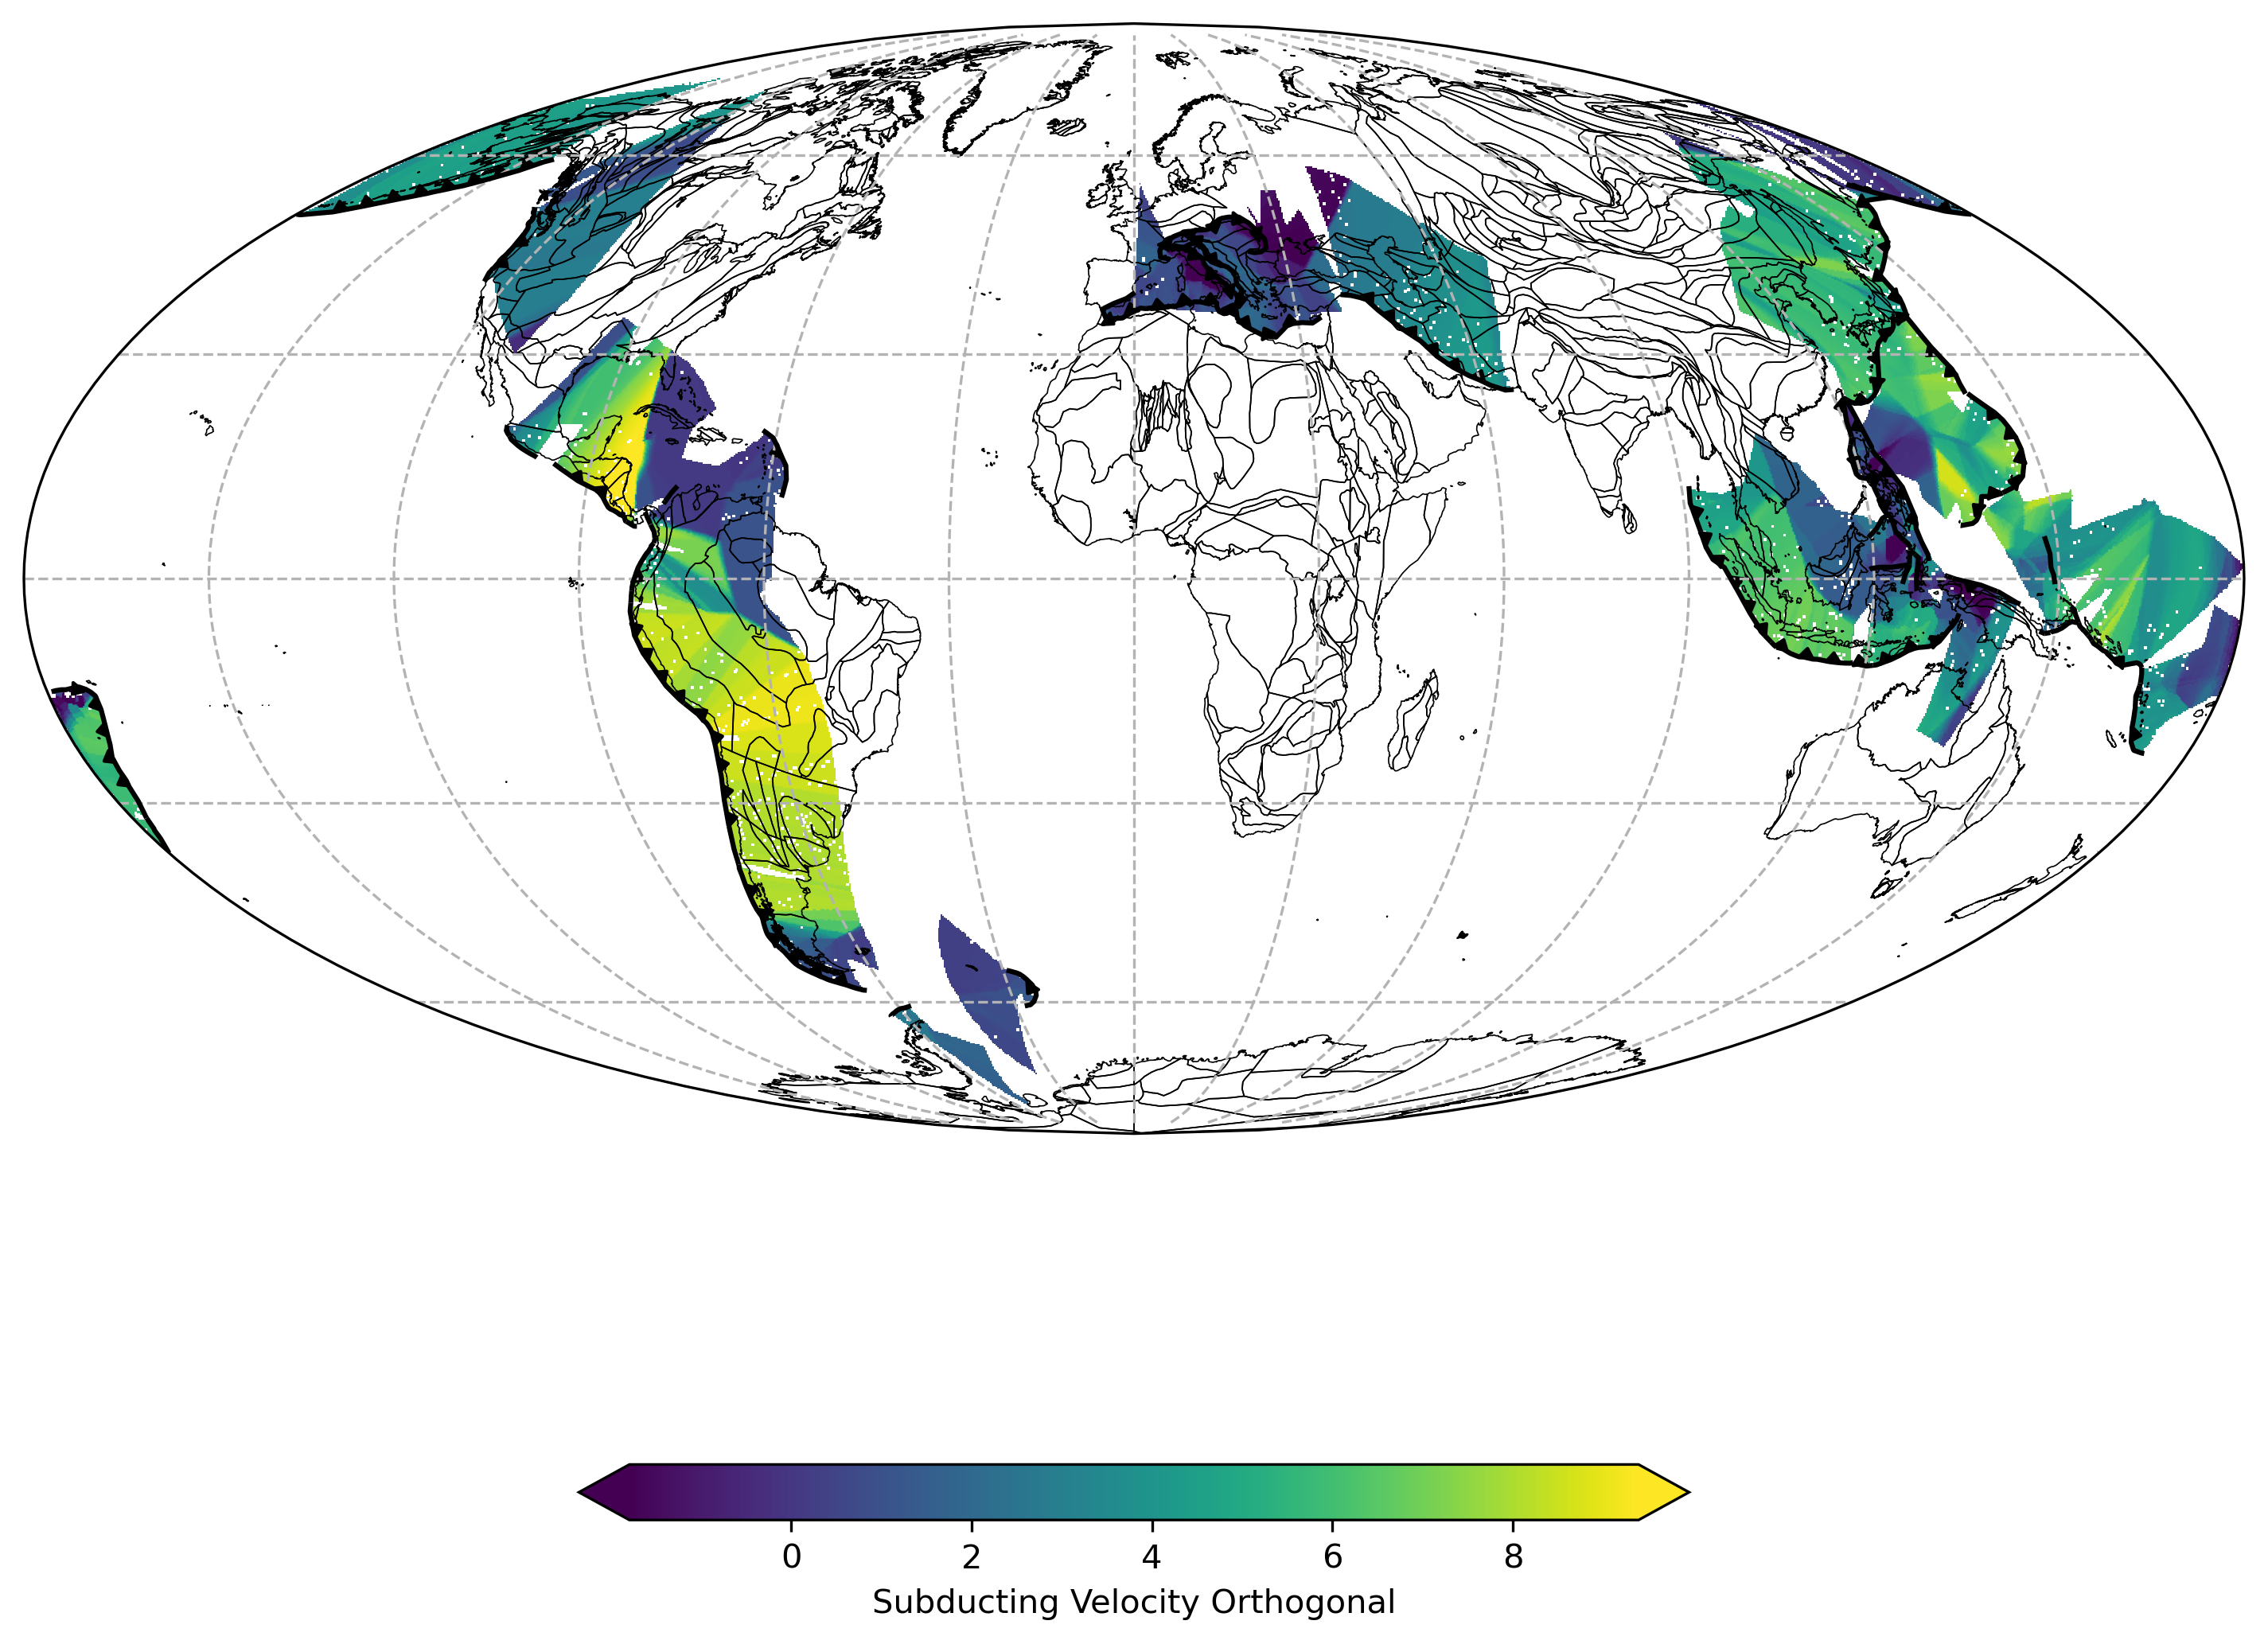

In [30]:
## Quick Plot
figsize=[12,12]
central_longitude=0
fig = plt.figure(figsize=figsize, dpi=300)    
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = central_longitude))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))

mollweide_proj = f"+proj=moll +lon_0={central_longitude} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
Data_gdf=Data3   
columns=Data_gdf.columns
column=columns[22]
gplot.plot_coastlines(ax=ax,color='none', edgecolor="black",linewidth=0.4)
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax=ax,color='k')
da=df_to_NetCDF(x=Data_gdf["Longitude"],y=Data_gdf["Latitude"],z=Data_gdf[column])
ds=da.to_dataset(name=column)
data = Data_gdf[column]

# Calculate mean and standard deviation
mean = data.mean()
std = data.std()

# Calculate vmin and vmax
vmin = mean - 2 * std
vmax = mean + 2 * std
kwargs={'vmin':vmin,'vmax':vmax}
k=gplot.plot_grid(ax=ax, grid=da,**kwargs)
# c=fig.colorbar(k, cax=ax)
ds[column].plot(ax=ax,vmin=vmin,vmax=vmax, cbar_kwargs={'orientation':'horizontal','shrink':0.5,
                                          'label':f'{column}'})


In [26]:
# def process_reconstruction_time(reconstruction_time, n_steps=20):
#     print(f"Processing Time {reconstruction_time} Ma")
#     subduction_df = PK.get_subductiondf(reconstruction_time, tessellation_threshold_deg=0.7)
#     subduction_lines = []
    
#     for i in range(0, len(subduction_df) - 1):
#         Point1 = (subduction_df.iloc[i]['Trench Longitude'], subduction_df.iloc[i]['Trench Latitude'])
#         Point2 = (subduction_df.iloc[i + 1]['Trench Longitude'], subduction_df.iloc[i + 1]['Trench Latitude'])
#         lines = LineString([Point1, Point2])
#         dist = lines.length
#         if dist <= 5.0:
#             subduction_lines.append(lines)
    
#     profiles = []
#     trench_lats = []
#     trench_lons = []

#     for i in range(0, len(subduction_df) - 1):
#         dlon1 = n_steps * np.sin(np.radians(subduction_df.iloc[i]['Subduction Normal Angle']))
#         dlat1 = n_steps * np.cos(np.radians(subduction_df.iloc[i]['Subduction Normal Angle']))
#         x1 = subduction_df.iloc[i]['Trench Longitude']
#         y1 = subduction_df.iloc[i]['Trench Latitude']
#         ilon1 = x1 + dlon1
#         ilat1 = y1 + dlat1
        
#         start_point = Point(x1 + 0.01 * dlon1, y1 + 0.01 * dlat1)
#         end_point = Point(ilon1, ilat1)
#         profile = LineString([start_point, end_point])
#         profiles.append(profile)
#         trench_lats.append(y1)
#         trench_lons.append(x1)
    
#     intersected_points = []
#     intersected_profiles = []
#     intersected_trench_lats = []
#     intersected_trench_lons = []
    
#     for i in range(len(profiles)):
#         for subduction_line in subduction_lines:
#             intersection = profiles[i].intersection(subduction_line)
#             if intersection.geom_type == 'Point':
#                 intersected_profiles.append(profiles[i])
#                 intersected_trench_lats.append(trench_lats[i])
#                 intersected_trench_lons.append(trench_lons[i])
#                 intersected_points.append(intersection)
                
#     Intersection_df = gpd.GeoDataFrame()
#     Intersection_df['Trench Latitude I'] = intersected_trench_lats
#     Intersection_df['Trench Longitude I'] = intersected_trench_lons
#     Intersection_df['Intersection Point'] = intersected_points
#     Intersection_df['Intersection Profile'] = intersected_profiles
#     Intersection_df['Intersection Latitude'] = Intersection_df['Intersection Point'].apply(lambda p: p.y)
#     Intersection_df['Intersection Longitude'] = Intersection_df['Intersection Point'].apply(lambda p: p.x)
#     Intersection_df = Intersection_df.set_geometry(gpd.points_from_xy(Intersection_df['Trench Longitude I'], Intersection_df['Trench Latitude I']))
    
#     result = gpd.sjoin_nearest(subduction_df, Intersection_df, how='left', max_distance=1.0)
#     result = result.reset_index()
#     result = result.drop_duplicates(subset=['index'], keep='first')
#     result = result.set_index('index')
#     result['Intersection Latitude'] = result['Intersection Latitude'].fillna(result['Trench Latitude'] + n_steps * np.cos(np.radians(result['Subduction Normal Angle'])))
#     result['Intersection Longitude'] = result['Intersection Longitude'].fillna(result['Trench Longitude'] + n_steps * np.sin(np.radians(result['Subduction Normal Angle'])))
    
#     point_lats = []
#     point_lons = []
#     results = Parallel(n_jobs=-1)(
#         delayed(poly_around_sub)(i, result, resolution=0.1) for i in range(len(result) - 1)
#     )
    
#     for i, res in enumerate(results):
#         try:
#             point_lats.extend(res['point_lats'])
#             point_lons.extend(res['point_lons'])
#         except Exception as e:
#             pass
    
#     da = df_to_NetCDF(x=point_lons, y=point_lats, z=np.ones(len(point_lons)), statistic='mean', grid_resolution=0.1)
#     da.name = "z"
#     Data = da.to_dataframe().reset_index()
#     Data = Data.dropna().reset_index().drop(columns=['index'])
#     Data_gdf = gpd.GeoDataFrame(Data, geometry=gpd.points_from_xy(Data['Longitude'], Data['Latitude']))
#     Data_gdf.rename(columns={'Longitude': 'Longitude a', 'Latitude': 'Latitude a'}, inplace=True)
    
#     Data2 = pd.read_parquet(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/CSV/Processed_WMA4/Processed_Data_{reconstruction_time}.parquet")
#     Data_gdf2 = gpd.GeoDataFrame(Data2, geometry=gpd.points_from_xy(Data2['Longitude'], Data2['Latitude']))
    
#     Data3 = gpd.sjoin_nearest(Data_gdf, Data_gdf2, how='left', distance_col='dist', max_distance=0.2)
#     Data3 = Data3.reset_index()
#     Data3 = Data3.drop_duplicates(subset=['index'], keep='first')
    
#     Data3.to_parquet(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/CSV/Processed_WMA4/Processed_Data_{reconstruction_time}.parquet")

# # List of all times to process
# # all_times2 = [10, 20, 30, 40]  # Example list

# # a = time.time()
# Parallel(n_jobs=-1)(delayed(process_reconstruction_time)(reconstruction_time) for reconstruction_time in all_times2[:1])
# # b = time.time()

# # print(b - a)


<Axes: >

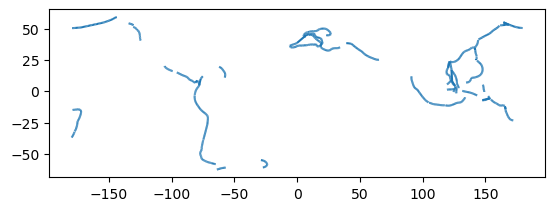

In [632]:
gdf.plot()

In [633]:
gdf.to_file("SZ.shp")

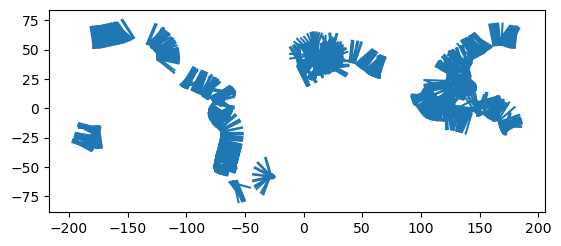

In [635]:
gdf=gpd.GeoDataFrame(geometry=profiles)
gdf.plot()
gdf.to_file("profiles.shp")

In [640]:
result

Trench Latitude  Trench Longitude  Convergence Rate  Migration Rate  \
index                                                                        
0            45.104169          7.562592          0.000000       -0.013701   
1            45.099686          7.577183          0.000000       -0.013709   
2            45.096282          7.588258          0.000000       -0.013705   
3            45.091796          7.602845          0.000000       -0.013707   
4            45.136550          7.706292          0.000867       -0.002837   
...                ...               ...               ...             ...   
1330         21.610729        120.720793          0.011065        0.008088   
1331         22.146491        120.888798          0.012874        0.006229   
1332         22.682079        121.058086          0.012876        0.006173   
1333         23.223552        121.253815          0.013363        0.005733   
1334         23.770810        121.476364          0.015620        0.003419   

       Subduction Velocity  Obliquity Angle  Subduction Normal Angle  \
index                                                                  
0                 0.000000         0.000000               203.515420   
1                 0.000000         0.000000               203.525755   
2                -0.004475       -90.005246               203.533600   
3                -0.003406      -133.636855               203.543931   
4                 0.003403       -75.232768               144.947467   
...                    ...              ...                      ...   
1330              0.011141         6.662493               106.193545   
1331              0.014855        29.931849               106.256151   
1332              0.014857        29.928554               106.320702   
1333              0.014857        25.916370               110.408359   
1334              0.021327        42.913424               110.497091   

       Subduction Length  Subduction Plate Velocity  \
index                                                 
0            1707.592878                   1.666151   
1             790.247858                   1.666763   
2            1106.126768                   1.667228   
3            1391.713973                   1.772181   
4           18282.175298                   1.772680   
...                  ...                        ...   
1330        62045.128920                  -1.927575   
1331        62045.128920                  -1.922329   
1332        62045.128920                  -1.916904   
1333        64946.393044                  -1.911149   
1334        64946.393044                  -1.905052   

       Subduction Plate Obliquity  ...  Subduction Volume Rate  \
index                              ...                           
0                     -145.318313  ...                0.000000   
1                     -145.332863  ...                0.000000   
2                     -145.343901  ...                0.000000   
3                     -154.990179  ...                0.000000   
4                      -96.412409  ...                0.000736   
...                           ...  ...                     ...   
1330                     6.477014  ...                0.042934   
1331                     6.494764  ...                0.051395   
1332                     6.513225  ...                0.051402   
1333                     2.515360  ...                0.056820   
1334                     2.523416  ...                0.072802   

       Plate Thickness  Subduction Flux  index_right  Trench Latitude I  \
index                                                                     
0         46436.070312         0.000000          1.0          45.104169   
1         46436.070312         0.000000          3.0          45.099686   
2         46436.070312         0.000000          4.0          45.096282   
3         46436.070312         0.000000          6.0          45.091796   
4         46436.070312        

In [641]:
gdf=gpd.GeoDataFrame(geometry=gpd.points_from_xy(result['Trench Longitude'],result['Trench Latitude']))

In [642]:
gdf.to_file("result.shp")

In [652]:
gdf=gpd.GeoDataFrame(geometry=gpd.points_from_xy(point_lons,point_lats))

<Axes: >

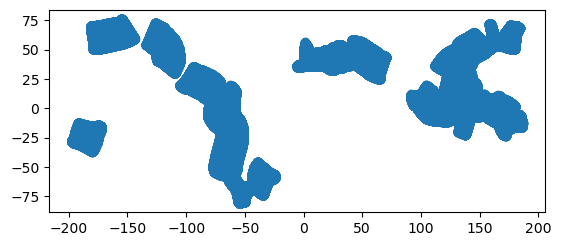

In [653]:
gdf.plot()

In [654]:
gdf.to_file("result.gpkg")

In [ ]:
import os
import numpy as np
import xarray as xr

def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def interpolate_and_save_as_nc(start_time, end_time, required_time_step=1):
    initial_time_step = int(end_time - start_time)
    
    try:
        # Open the NetCDF files with xarray
        src_start = xr.open_dataset(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/NetCDF/RF/RF_Model_phase2_{start_time}.nc")
        src_end = xr.open_dataset(f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/NetCDF/RF/RF_Model_phase2_{end_time}.nc")

        # Get the data variable name (replace 'ElevationRF (Ca)' with the actual data variable name if different)
        data_variable_name = 'Paleotopography'  # Ensure this matches the variable name in your files
        start_data = src_start[data_variable_name]
        end_data = src_end[data_variable_name]

        # Extract lat/lon variables
        latitudes = src_start['Latitude']
        longitudes = src_start['Longitude']

        # Define the interpolation time steps
        time_steps = range(1, initial_time_step, required_time_step)

        for time in time_steps:
            # Calculate the interpolated data using your formula
            time_fraction = time / float(initial_time_step)
            interpolated_data = start_data + (end_data - start_data) * time_fraction

            # Prepare NetCDF parameters
            output_nc = f"/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography/NetCDF/RF/RF_Model_phase2_{start_time+time}.nc"
            create_directory_if_not_exists(os.path.dirname(output_nc))
            
            # Create a new xarray Dataset for the interpolated data
            ds_interpolated = xr.Dataset(
                {
                    data_variable_name: (['Latitude', 'Longitude'], interpolated_data.values),
                },
                coords={
                    'Latitude': latitudes,
                    'Longitude': longitudes,
                }
            )
            
            # Copy attributes from source files
            ds_interpolated.attrs.update(src_start.attrs)
            ds_interpolated[data_variable_name].attrs.update(src_start[data_variable_name].attrs)
            
            # Save to NetCDF with compression
            ds_interpolated.to_netcdf(output_nc, mode='w', engine='netcdf4', format='NETCDF4', encoding={data_variable_name: {'zlib': True, 'complevel': 5}})
            
        print(f"Interpolation completed from {start_time} Ma to {end_time} Ma.")

    except Exception as e:
        print(f"No raster file for interpolating from {start_time} Ma to {end_time} Ma: {e}")

# Example usage:
# i = 10
# all_times = [13, 14, 15]  # Example times, update with your actual time steps
# interpolate_and_save_as_nc(start_time=all_times[i], end_time=all_times[i+1], required_time_step=1)
all_times=glob.glob("/Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/DeepTimeTopo/Workflow/Paleotopography//NetCDF/RF/RF_Model_phase2_*.nc")

# all_times=glob.glob(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA3/*")
all_times=np.sort([int(time.split('_')[-1].split('.')[0]) for time in all_times])
for i in range(len(all_times)-1):
    interpolate_and_save_as_nc(start_time=all_times[i], end_time=all_times[i+1], required_time_step=1)